# Previsão de gasto de energia elétrica KwH

### Link dos dados:
https://www.kaggle.com/datasets/govindaramsriramenergy-consumption-dataset-linear-regression

Este projeto analisa o consumo de energia elétrica por meio de uma exploração de dados (EDA), identificando padrões, tendências e possíveis outliers. Com base nessa análise, construímos um modelo de regressão linear para prever o consumo de energia, permitindo entender como cada variável influencia os valores e avaliando o desempenho de previsões lineares no dataset. O trabalho combina análise de dados e modelagem preditiva, oferecendo insights úteis para decisões relacionadas ao consumo de energia.

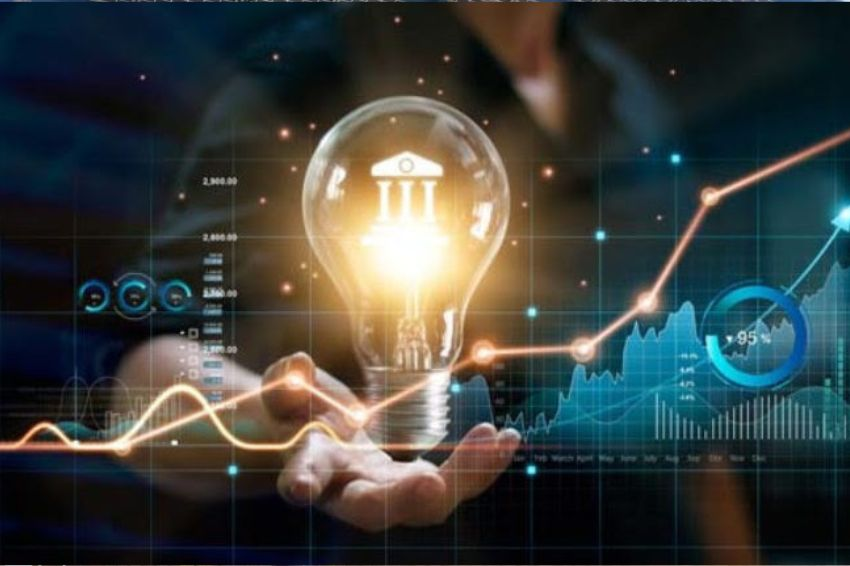

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")

In [2]:
data = pd.read_csv('/content/drive/MyDrive/regressao_linear/train_energy_data.csv')

In [3]:
data.head()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
0   Residential            7063                   76               10   
1    Commercial           44372                   66               45   
2    Industrial           19255                   37               17   
3   Residential           13265                   14               41   
4    Commercial           13375                   26               18   

   Average Temperature Day of Week  Energy Consumption  
0                29.84     Weekday             2713.95  
1                16.72     Weekday             5744.99  
2                14.30     Weekend             4101.24  
3                32.82     Weekday             3009.14  
4                11.92     Weekday             3279.17

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Building Type        1000 non-null   object 
 1   Square Footage       1000 non-null   int64  
 2   Number of Occupants  1000 non-null   int64  
 3   Appliances Used      1000 non-null   int64  
 4   Average Temperature  1000 non-null   float64
 5   Day of Week          1000 non-null   object 
 6   Energy Consumption   1000 non-null   float64
dtypes: float64(2), int64(3), object(2)
memory usage: 54.8+ KB


In [5]:
data.isnull().sum()

Building Type          0
Square Footage         0
Number of Occupants    0
Appliances Used        0
Average Temperature    0
Day of Week            0
Energy Consumption     0
dtype: int64

In [6]:
data.shape

(1000, 7)

In [7]:
data.nunique()

Building Type             3
Square Footage          986
Number of Occupants      99
Appliances Used          49
Average Temperature     833
Day of Week               2
Energy Consumption     1000
dtype: int64

In [8]:
data.describe()

Square Footage  Number of Occupants  Appliances Used  \
count        1000.000          1000.000000      1000.000000   
mean        25462.388            48.372000        25.606000   
std         14294.554            29.061972        14.105166   
min           560.000             1.000000         1.000000   
25%         13169.750            22.000000        13.000000   
50%         25477.000            47.000000        26.000000   
75%         37446.250            73.250000        38.000000   
max         49997.000            99.000000        49.000000   

       Average Temperature  Energy Consumption  
count          1000.000000         1000.000000  
mean             22.611390         4166.252570  
std               7.139943          933.313064  
min              10.050000         1683.950000  
25%              16.475000         3509.482500  
50%              22.815000         4175.730000  
75%              28.850000         4863.850000  
max              34.990000         6530.600000

In [9]:
data.describe(include='all').transpose()

count unique          top freq        mean         std  \
Building Type          1000      3  Residential  347         NaN         NaN   
Square Footage       1000.0    NaN          NaN  NaN   25462.388   14294.554   
Number of Occupants  1000.0    NaN          NaN  NaN      48.372   29.061972   
Appliances Used      1000.0    NaN          NaN  NaN      25.606   14.105166   
Average Temperature  1000.0    NaN          NaN  NaN    22.61139    7.139943   
Day of Week            1000      2      Weekday  507         NaN         NaN   
Energy Consumption   1000.0    NaN          NaN  NaN  4166.25257  933.313064   

                         min        25%      50%       75%      max  
Building Type            NaN        NaN      NaN       NaN      NaN  
Square Footage         560.0   13169.75  25477.0  37446.25  49997.0  
Number of Occupants      1.0       22.0     47.0     73.25     99.0  
Appliances Used          1.0       13.0     26.0      38.0     49.0  
Average Temperature    10.05     16.475   22.815     28.85    34.99  
Day of Week              NaN        NaN      NaN       NaN      NaN  
Energy Consumption   1683.95  3509.4825  4175.73   4863.85   6530.6

###Feature engineering

In [10]:
data['densidade_ocupacao'] = round(data['Square Footage']/data['Number of Occupants'])
data['consumo_por_m2_p_1000'] = round(data['Energy Consumption']/data['Square Footage']*1000)
data['consumo_por_ocupante'] = round(data['Energy Consumption']/data['Number of Occupants'])

In [11]:
data.head()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
0   Residential            7063                   76               10   
1    Commercial           44372                   66               45   
2    Industrial           19255                   37               17   
3   Residential           13265                   14               41   
4    Commercial           13375                   26               18   

   Average Temperature Day of Week  Energy Consumption  densidade_ocupacao  \
0                29.84     Weekday             2713.95                93.0   
1                16.72     Weekday             5744.99               672.0   
2                14.30     Weekend             4101.24               520.0   
3                32.82     Weekday             3009.14               948.0   
4                11.92     Weekday             3279.17               514.0   

   consumo_por_m2_p_1000  consumo_por_ocupante  
0                  384.0                  36.0  
1                  129.0                  87.0  
2                  213.0                 111.0  
3                  227.0                 215.0  
4                  245.0                 126.0

In [12]:
#função faixas
def faixas_ocupantes(ocupantes):
  if ocupantes <= 25:
    return "Entre 1 e 25 Ocup."
  elif ocupantes > 25 and ocupantes <= 50:
    return "Entre 26 e 50 Ocup."
  elif ocupantes > 50 and ocupantes <= 75:
    return "Entre 51 e 75 Ocup."
  else:
    return "Entre 75 e 99"

def faixas_eletros(eletros):
  if eletros <= 10:
    return "Entre 1 e 10 elet."
  elif eletros > 10 and eletros <= 20:
    return "Entre 10 e 20 elet."
  elif eletros > 20 and eletros <= 30:
    return "Entre 20 e 30 elet."
  elif eletros > 30 and eletros <= 40:
    return "Entre 30 e 40 elet."
  elif eletros > 40 and eletros <= 49:
    return "Entre 40 e 49 ele."

def faixas_consumo(consumo):
  if consumo <= 3200:
    return "2352-3200 Kwh"
  elif consumo > 3200 and consumo <= 4000:
    return "3201-4000 Kwh"
  elif consumo > 4000 and consumo <= 4800:
    return "4001-4800 Kwh"
  else:
    return "4801-6042 Kwh"



In [13]:
data['Faixa_ocupantes'] = data['Number of Occupants'].apply(faixas_ocupantes)
data['Faixa_eletros'] = data['Appliances Used'].apply(faixas_eletros)
data['Faixa_consumo'] = data['Energy Consumption'].apply(faixas_consumo)

In [14]:
data.head()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
0   Residential            7063                   76               10   
1    Commercial           44372                   66               45   
2    Industrial           19255                   37               17   
3   Residential           13265                   14               41   
4    Commercial           13375                   26               18   

   Average Temperature Day of Week  Energy Consumption  densidade_ocupacao  \
0                29.84     Weekday             2713.95                93.0   
1                16.72     Weekday             5744.99               672.0   
2                14.30     Weekend             4101.24               520.0   
3                32.82     Weekday             3009.14               948.0   
4                11.92     Weekday             3279.17               514.0   

   consumo_por_m2_p_1000  consumo_por_ocupante      Faixa_ocupantes  \
0                  384.0                  36.0        Entre 75 e 99   
1                  129.0                  87.0  Entre 51 e 75 Ocup.   
2                  213.0                 111.0  Entre 26 e 50 Ocup.   
3                  227.0                 215.0   Entre 1 e 25 Ocup.   
4                  245.0                 126.0  Entre 26 e 50 Ocup.   

         Faixa_eletros  Faixa_consumo  
0   Entre 1 e 10 elet.  2352-3200 Kwh  
1   Entre 40 e 49 ele.  4801-6042 Kwh  
2  Entre 10 e 20 elet.  4001-4800 Kwh  
3   Entre 40 e 49 ele.  2352-3200 Kwh  
4  Entre 10 e 20 elet.  3201-4000 Kwh

##EDA

Análise Univaridade Geral

In [15]:
lista = ['Square Footage', 'Number of Occupants', 'Appliances Used', 'Average Temperature', 'Energy Consumption','densidade_ocupacao', 'consumo_por_m2_p_1000', 'consumo_por_ocupante' ]

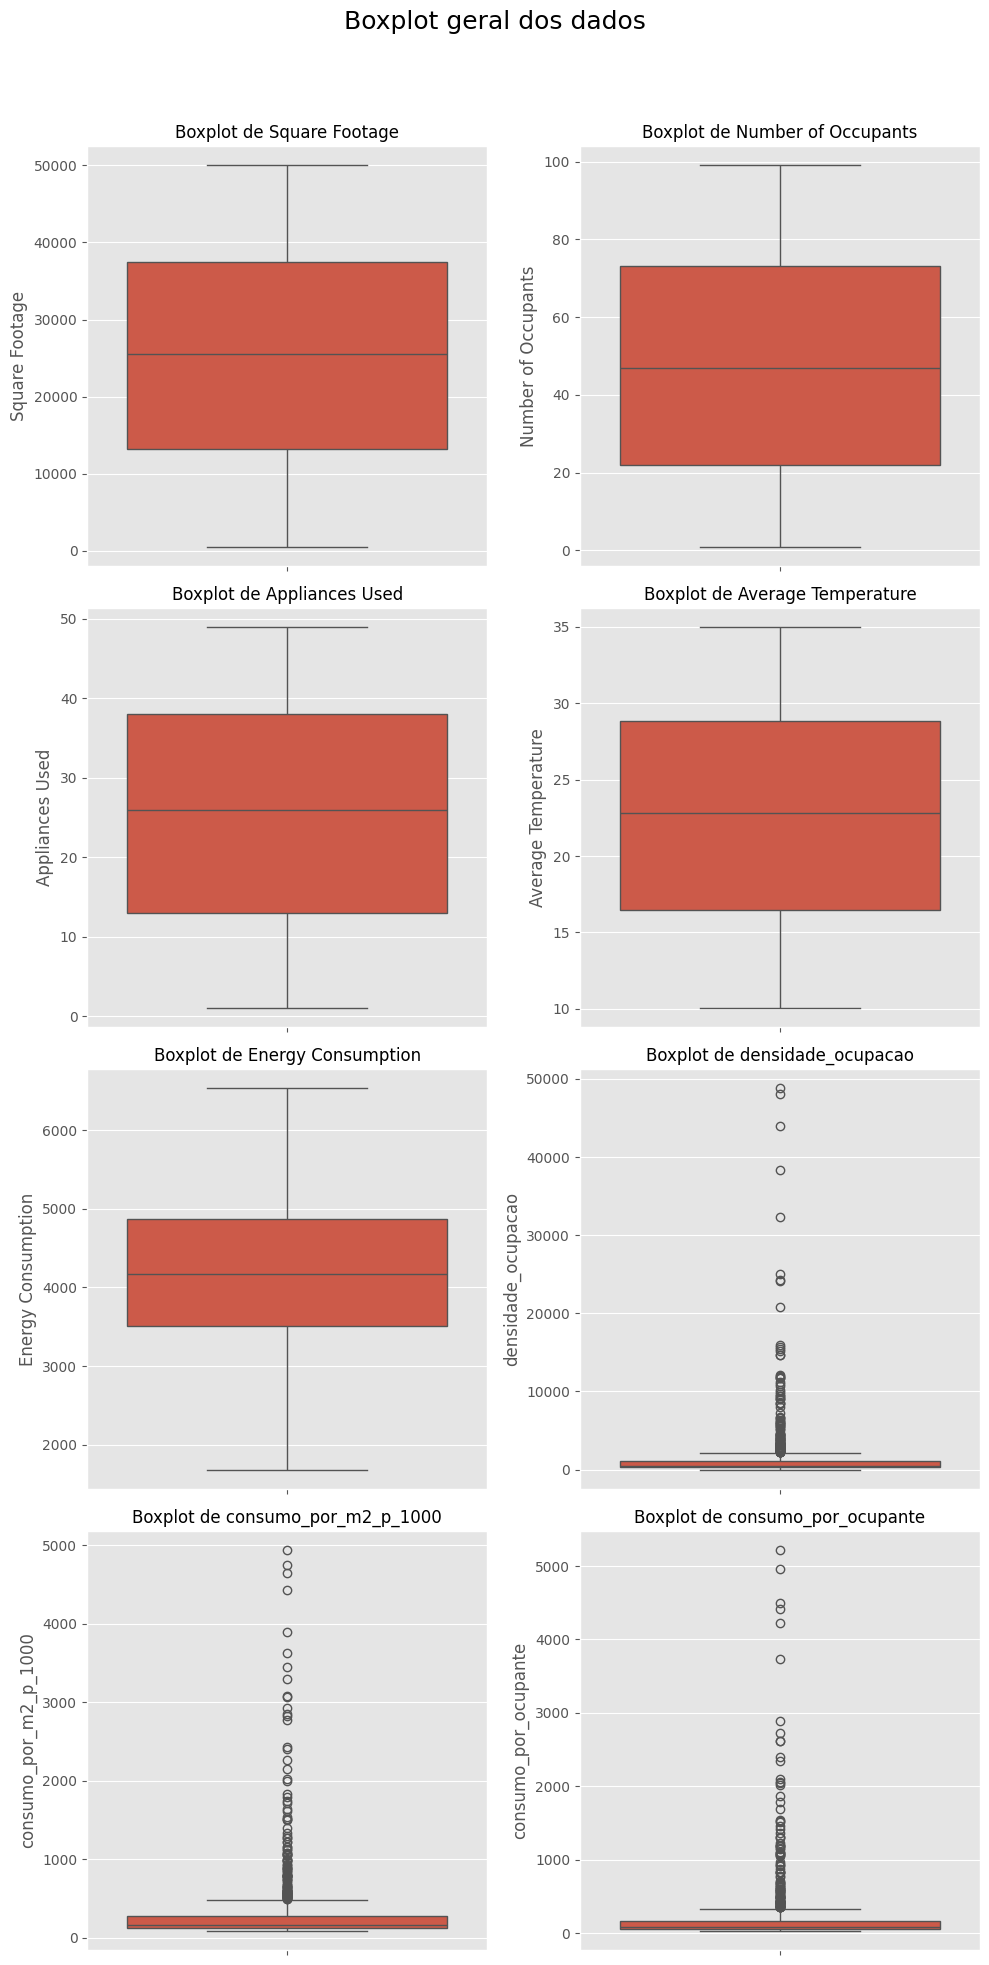

In [16]:
num_cols = 2
num_rows = 4



fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))
plt.suptitle('Boxplot geral dos dados', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.boxplot(y=data[col], ax=ax)
    ax.set_title(f'Boxplot de {col}', fontsize=12)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

# Reserva espaço para o suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show();

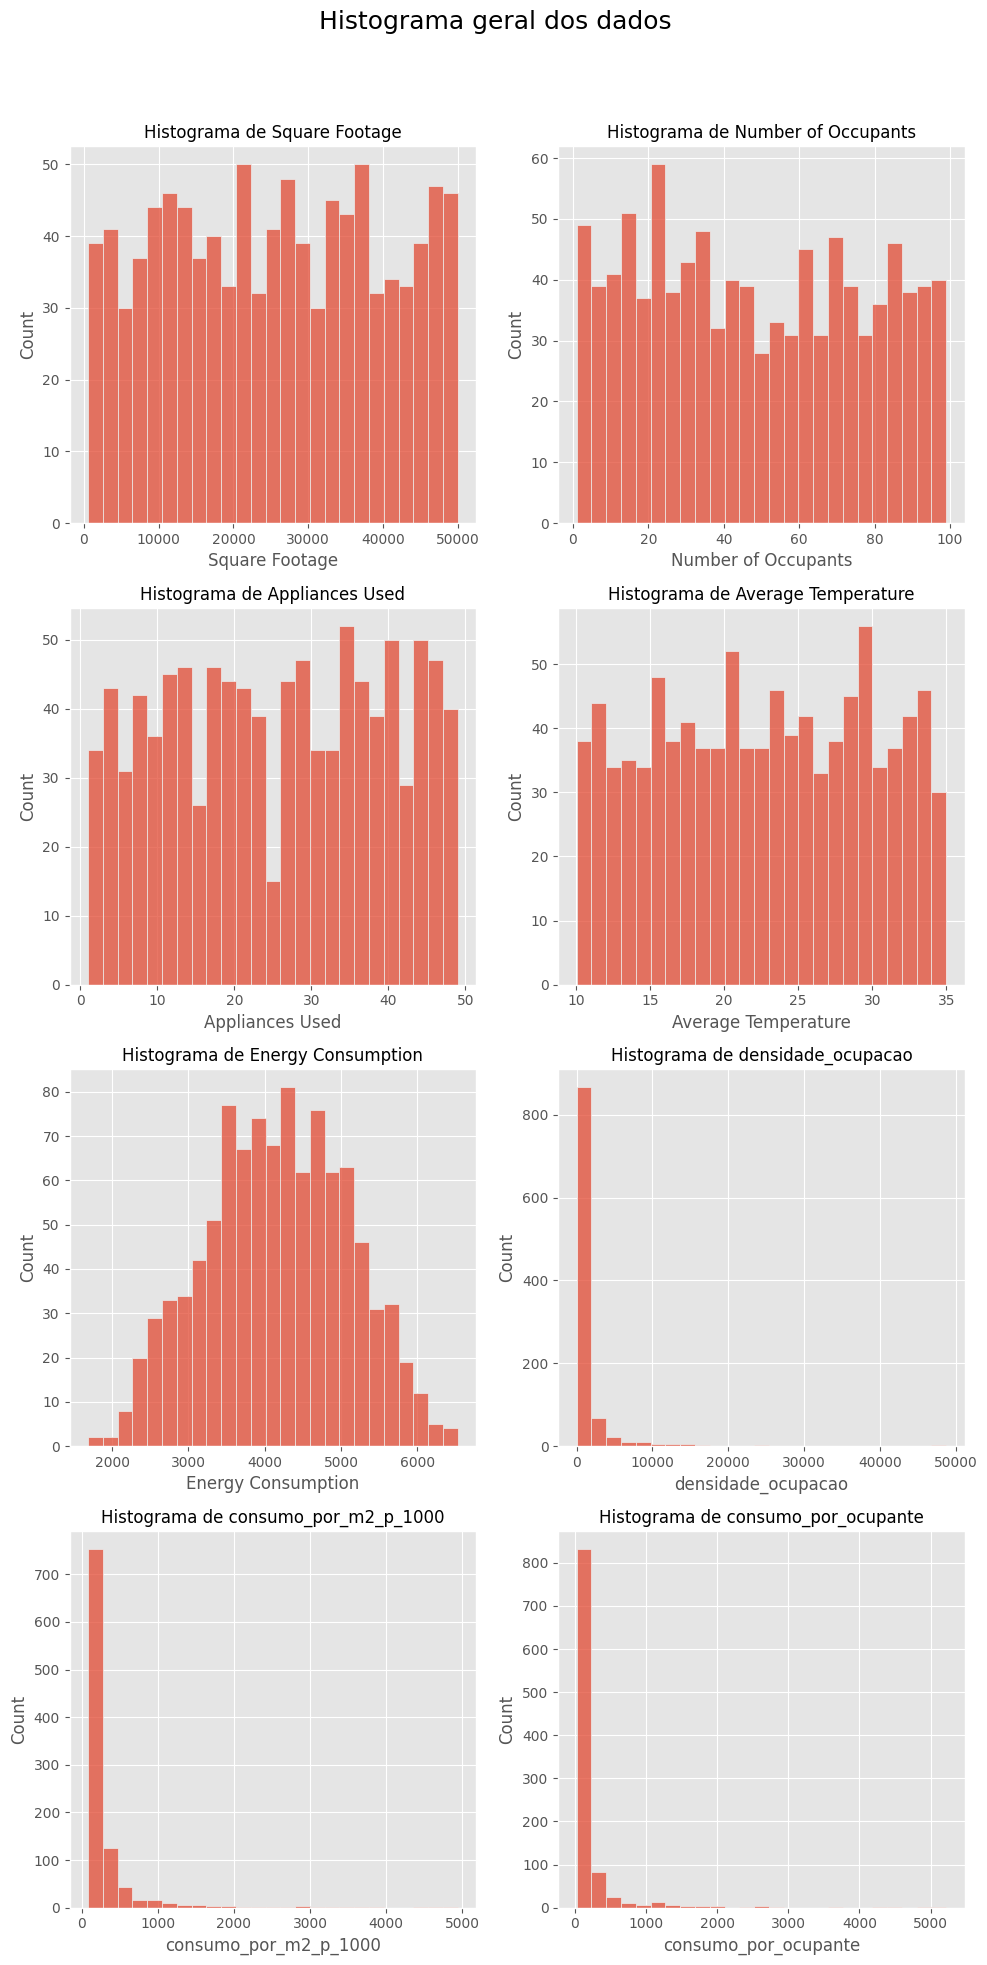

In [17]:
num_cols = 2
num_rows = 4


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

plt.suptitle('Histograma geral dos dados', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.histplot(data[col], kde=False, ax=ax, bins=25)
    ax.set_title(f'Histograma de {col}',fontsize=12)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

# Reserva espaço para o suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()

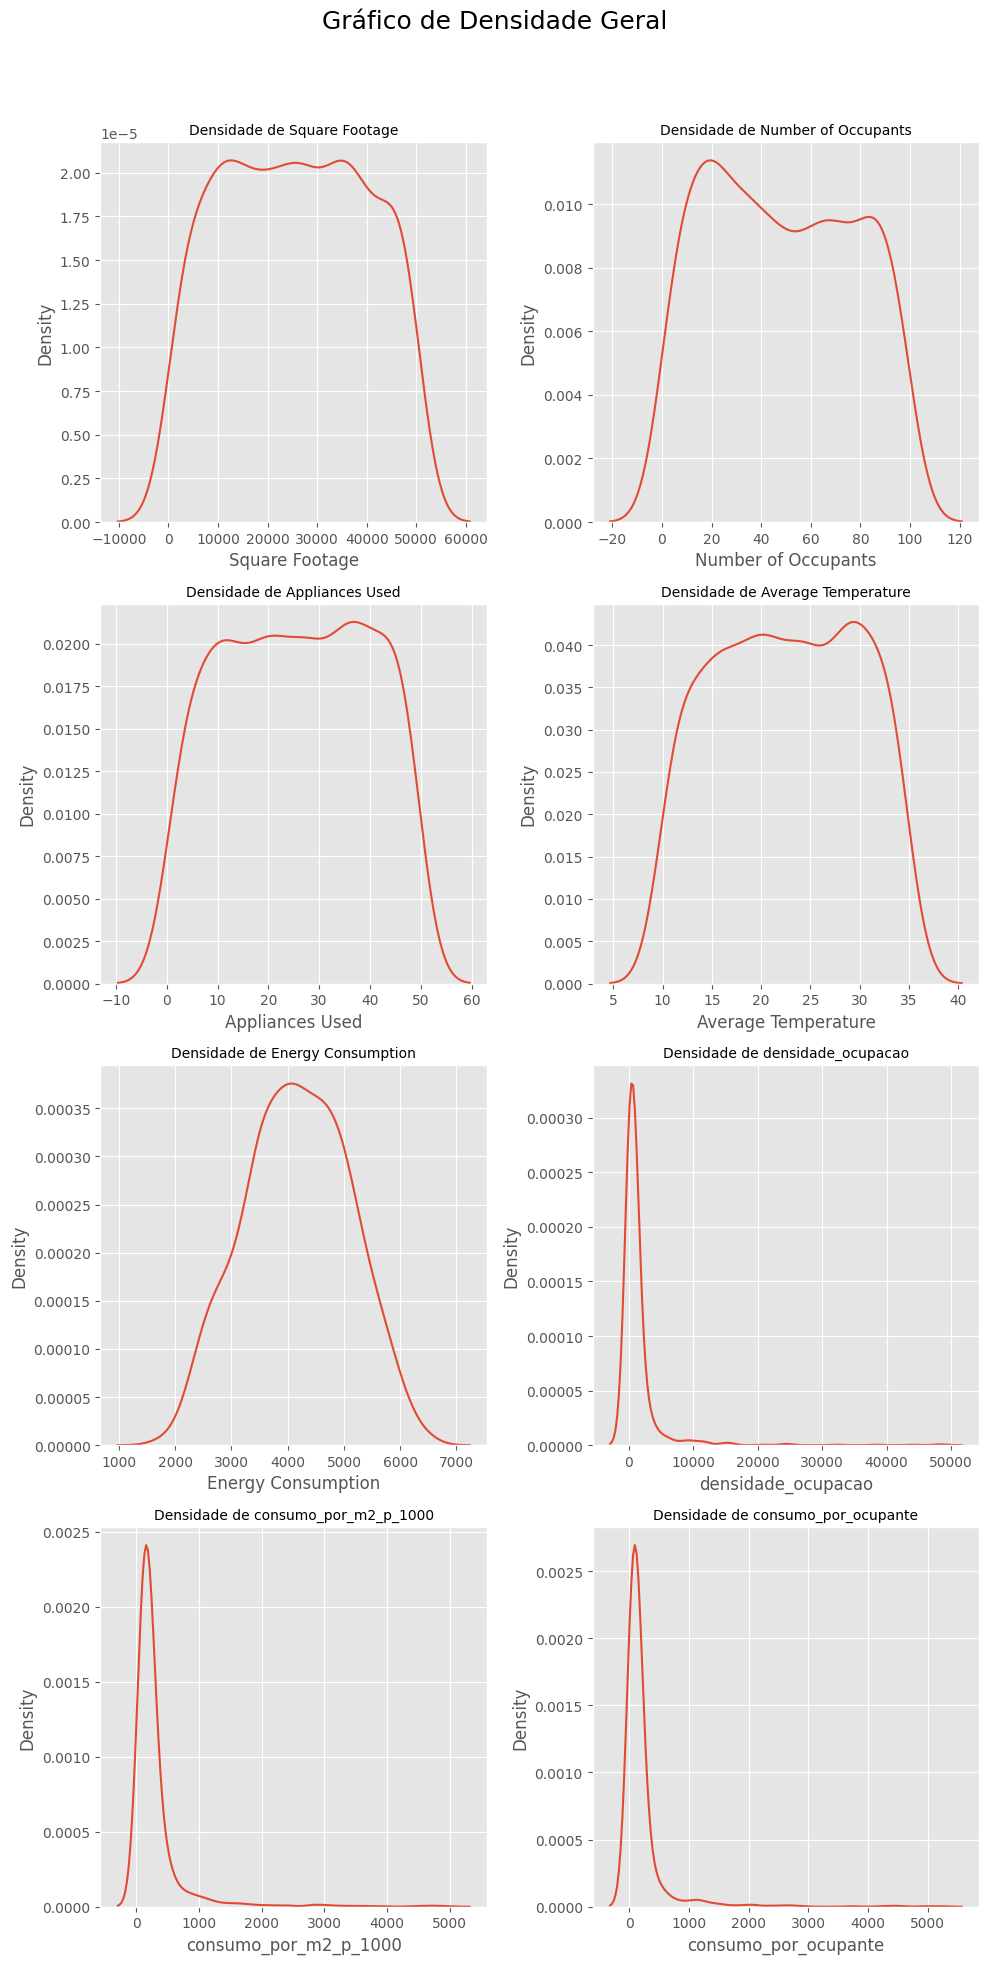

In [18]:

num_cols = 2
num_rows = 4


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

plt.suptitle('Gráfico de Densidade Geral', fontsize=18)


axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.kdeplot(data[col], ax=ax)
    ax.set_title(f'Densidade de {col}',fontsize=10)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

# Reserva espaço para o suptitle
plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()


In [19]:
#Building Type
#Day of Week
Building_Type = round(data['Building Type'].value_counts( normalize=True ) * 100, 1 )
Day_of_Week = round(data['Day of Week'].value_counts( normalize=True ) * 100, 1 )

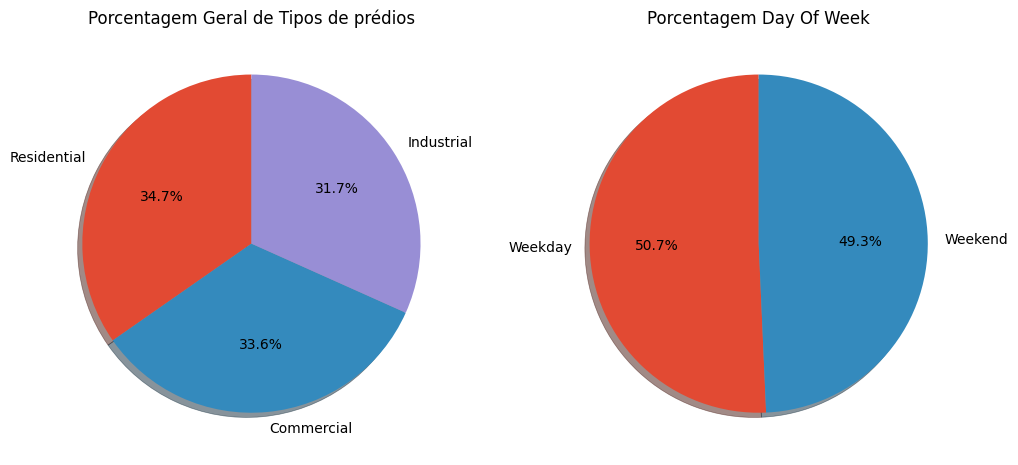

In [20]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.title('Porcentagem Geral de Tipos de prédios', fontsize=12)
plt.pie(
    Building_Type,
    labels = Building_Type.index,
    shadow=True,
    startangle=90,
    autopct='%1.1f%%'
);


plt.subplot(1, 2, 2)
plt.title('Porcentagem Day Of Week', fontsize=12)
plt.pie(
    Day_of_Week,
    labels = Day_of_Week.index,
    shadow=True,
    startangle=90,
    autopct='%1.1f%%'
);

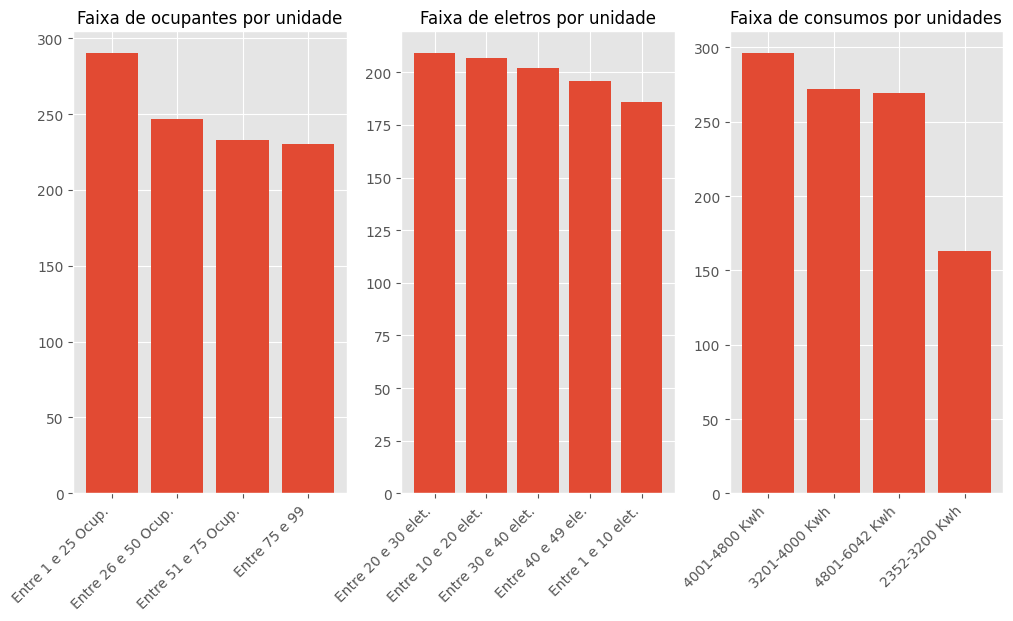

In [21]:
#Faixa_ocupantes	Faixa_eletros	Faixa_consumo
plt.figure(figsize=(12, 6))


plt.subplot(1, 3, 1)
plt.title("Faixa de ocupantes por unidade", fontsize = 12)
plt.bar( data['Faixa_ocupantes'].value_counts().index, data['Faixa_ocupantes'].value_counts());
plt.xticks( rotation=45, ha='right' );
plt.show;


plt.subplot(1, 3, 2)
plt.title("Faixa de eletros por unidade", fontsize = 12)
plt.bar( data['Faixa_eletros'].value_counts().index, data['Faixa_eletros'].value_counts());
plt.xticks( rotation=45, ha='right' );
plt.show;

plt.subplot(1, 3, 3)
plt.title("Faixa de consumos por unidades", fontsize = 12)
plt.bar( data['Faixa_consumo'].value_counts().index, data['Faixa_consumo'].value_counts());
plt.xticks( rotation=45, ha='right' );
plt.show;

###Análise Bivariada

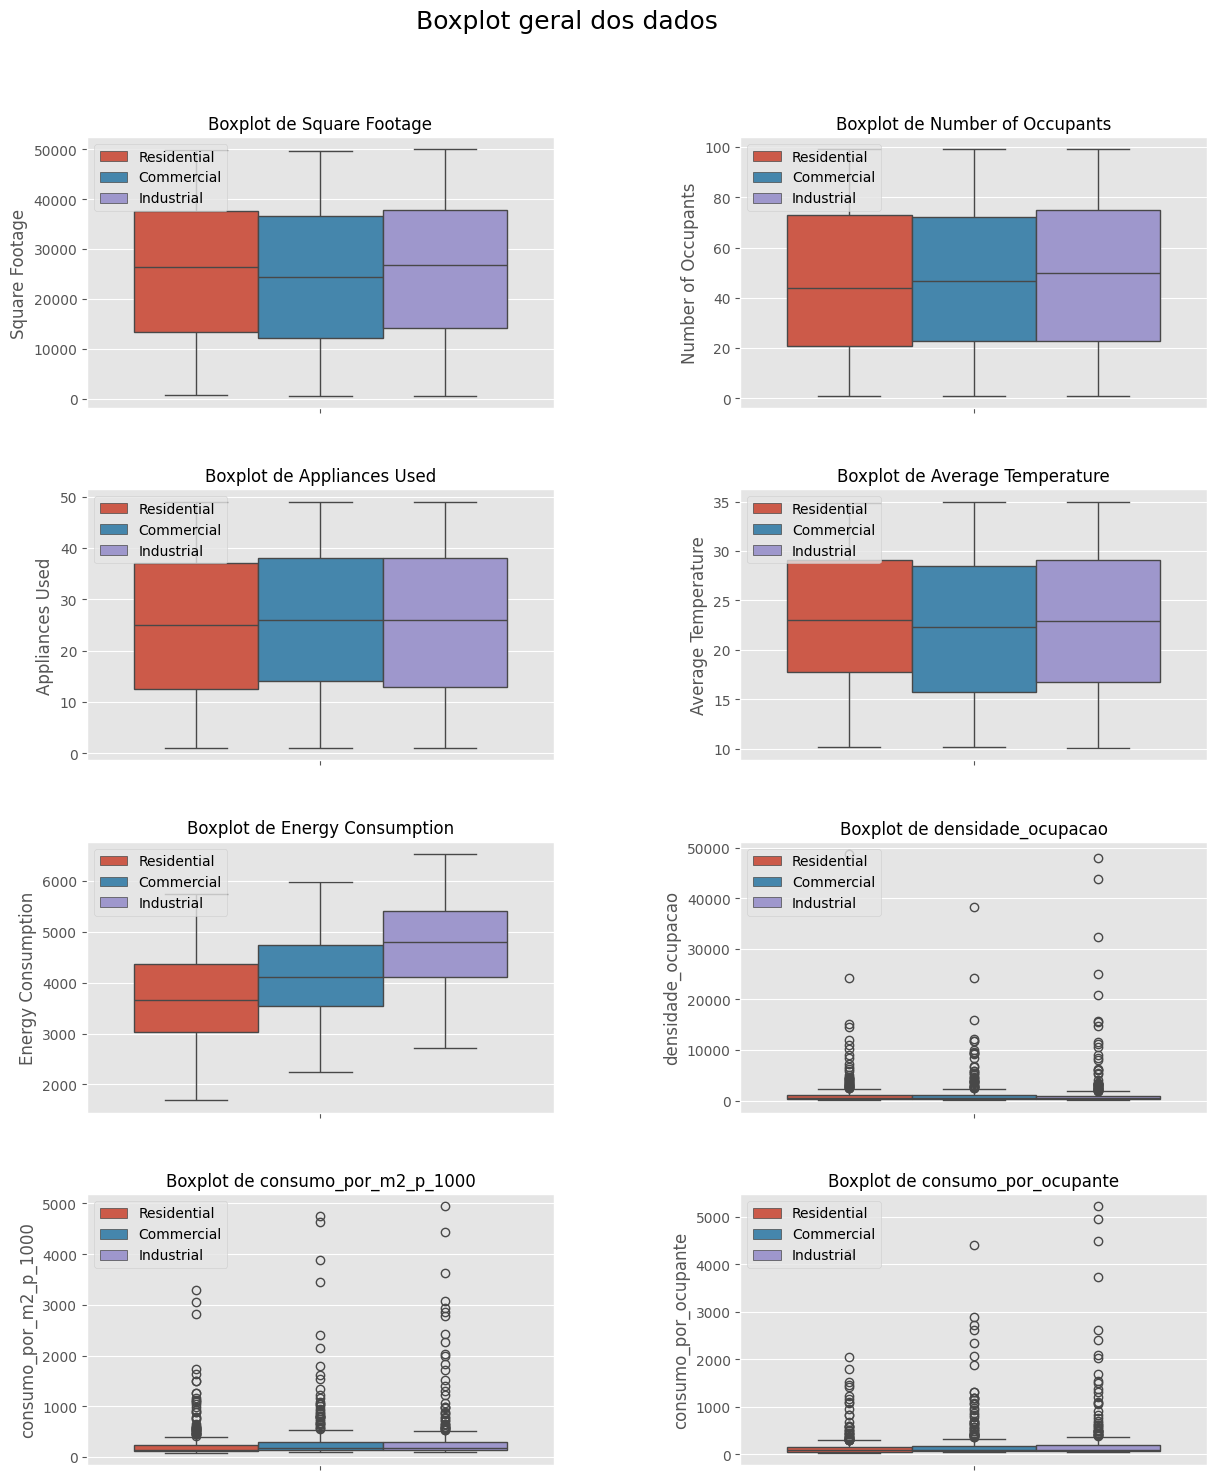

In [22]:

num_cols = 2
num_rows = 4



fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 4 * num_rows))
plt.suptitle('Boxplot geral dos dados', fontsize=18, y=1.01,x=0.4)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.boxplot(y=data[col], ax=ax, hue= data['Building Type'])
    ax.set_title(f'Boxplot de {col}', fontsize=12)
    ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show();

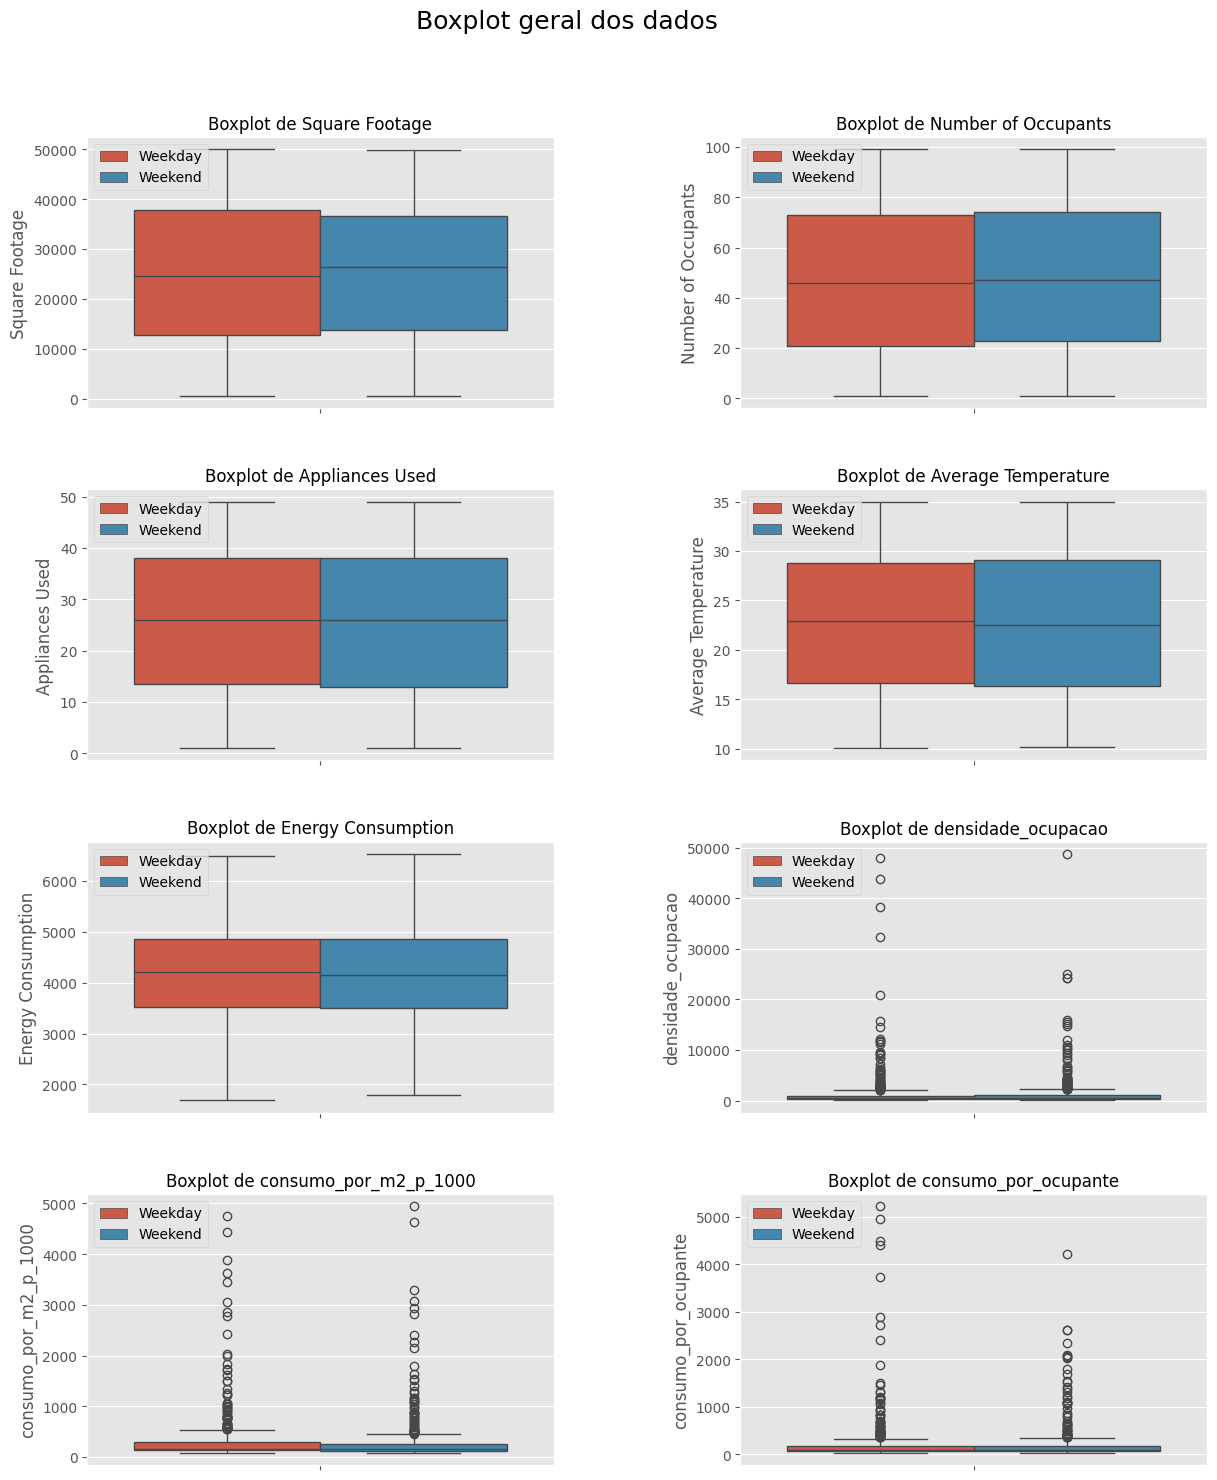

In [23]:

num_cols = 2
num_rows = 4



fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 4 * num_rows))
plt.suptitle('Boxplot geral dos dados', fontsize=18, y=1.01,x=0.4)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.boxplot(y=data[col], ax=ax, hue= data['Day of Week'])
    ax.set_title(f'Boxplot de {col}', fontsize=12)
    ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show();

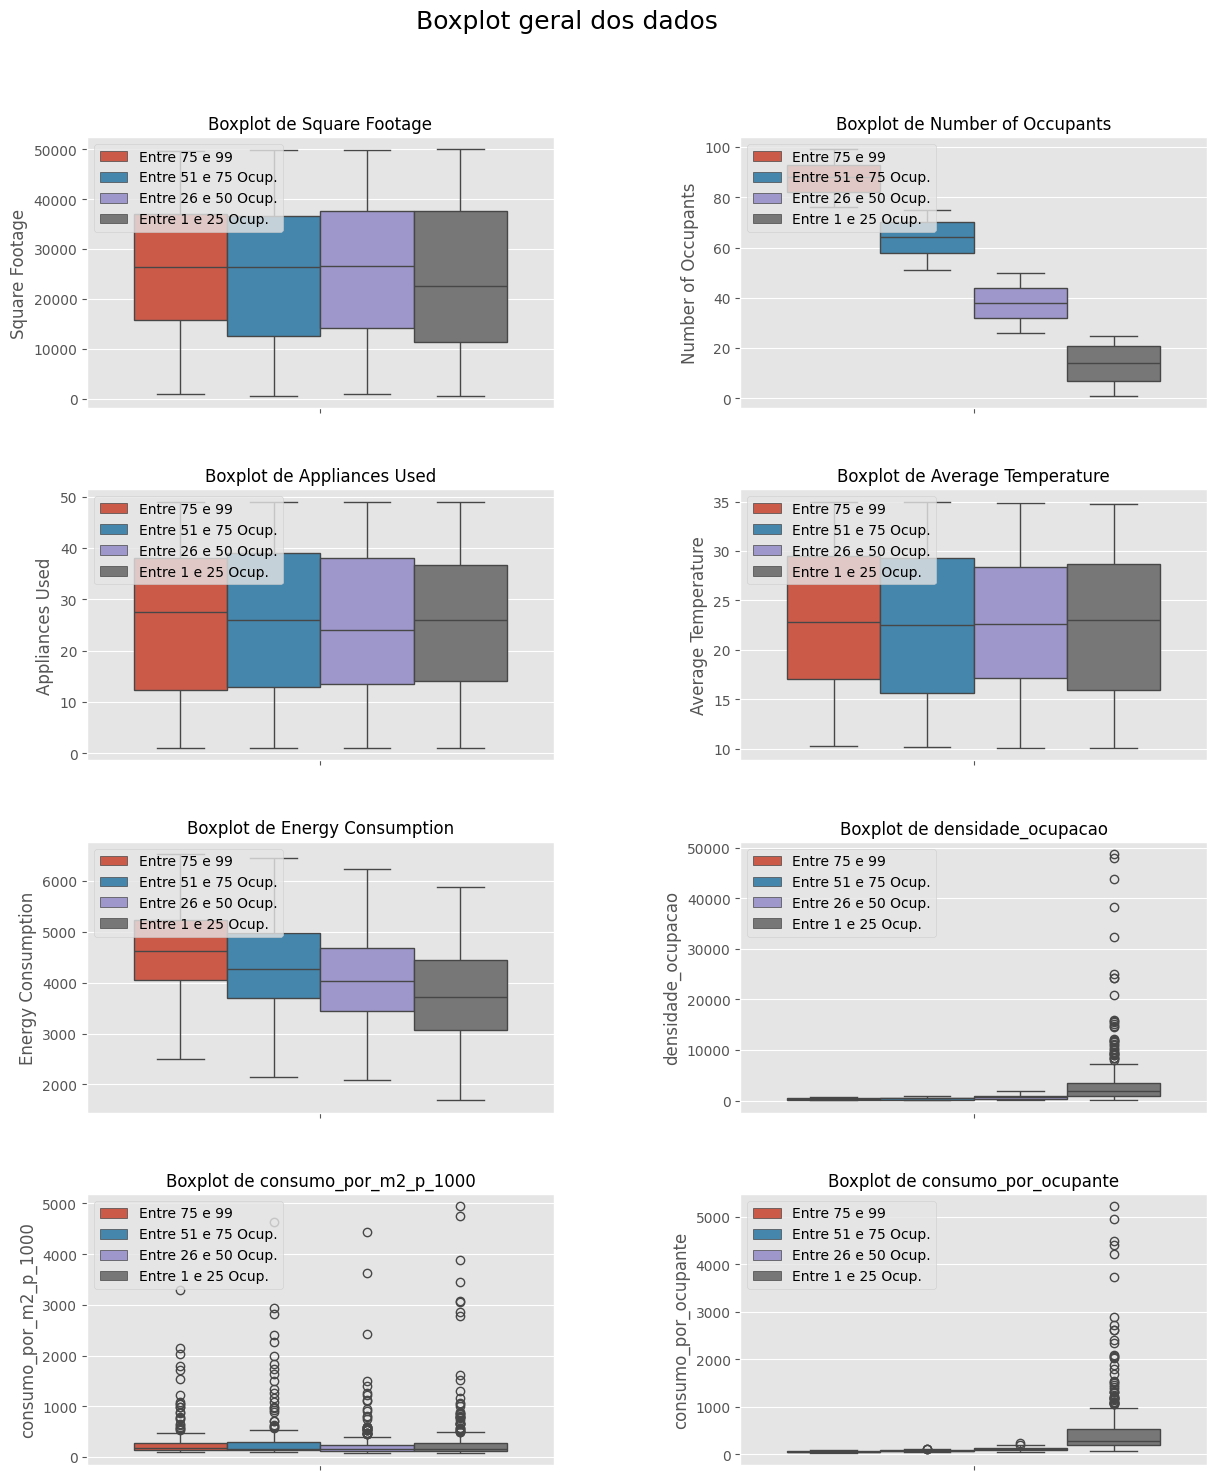

In [24]:

num_cols = 2
num_rows = 4



fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 4 * num_rows))
plt.suptitle('Boxplot geral dos dados', fontsize=18, y=1.01,x=0.4)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.boxplot(y=data[col], ax=ax, hue= data['Faixa_ocupantes'])
    ax.set_title(f'Boxplot de {col}', fontsize=12)
    ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show();

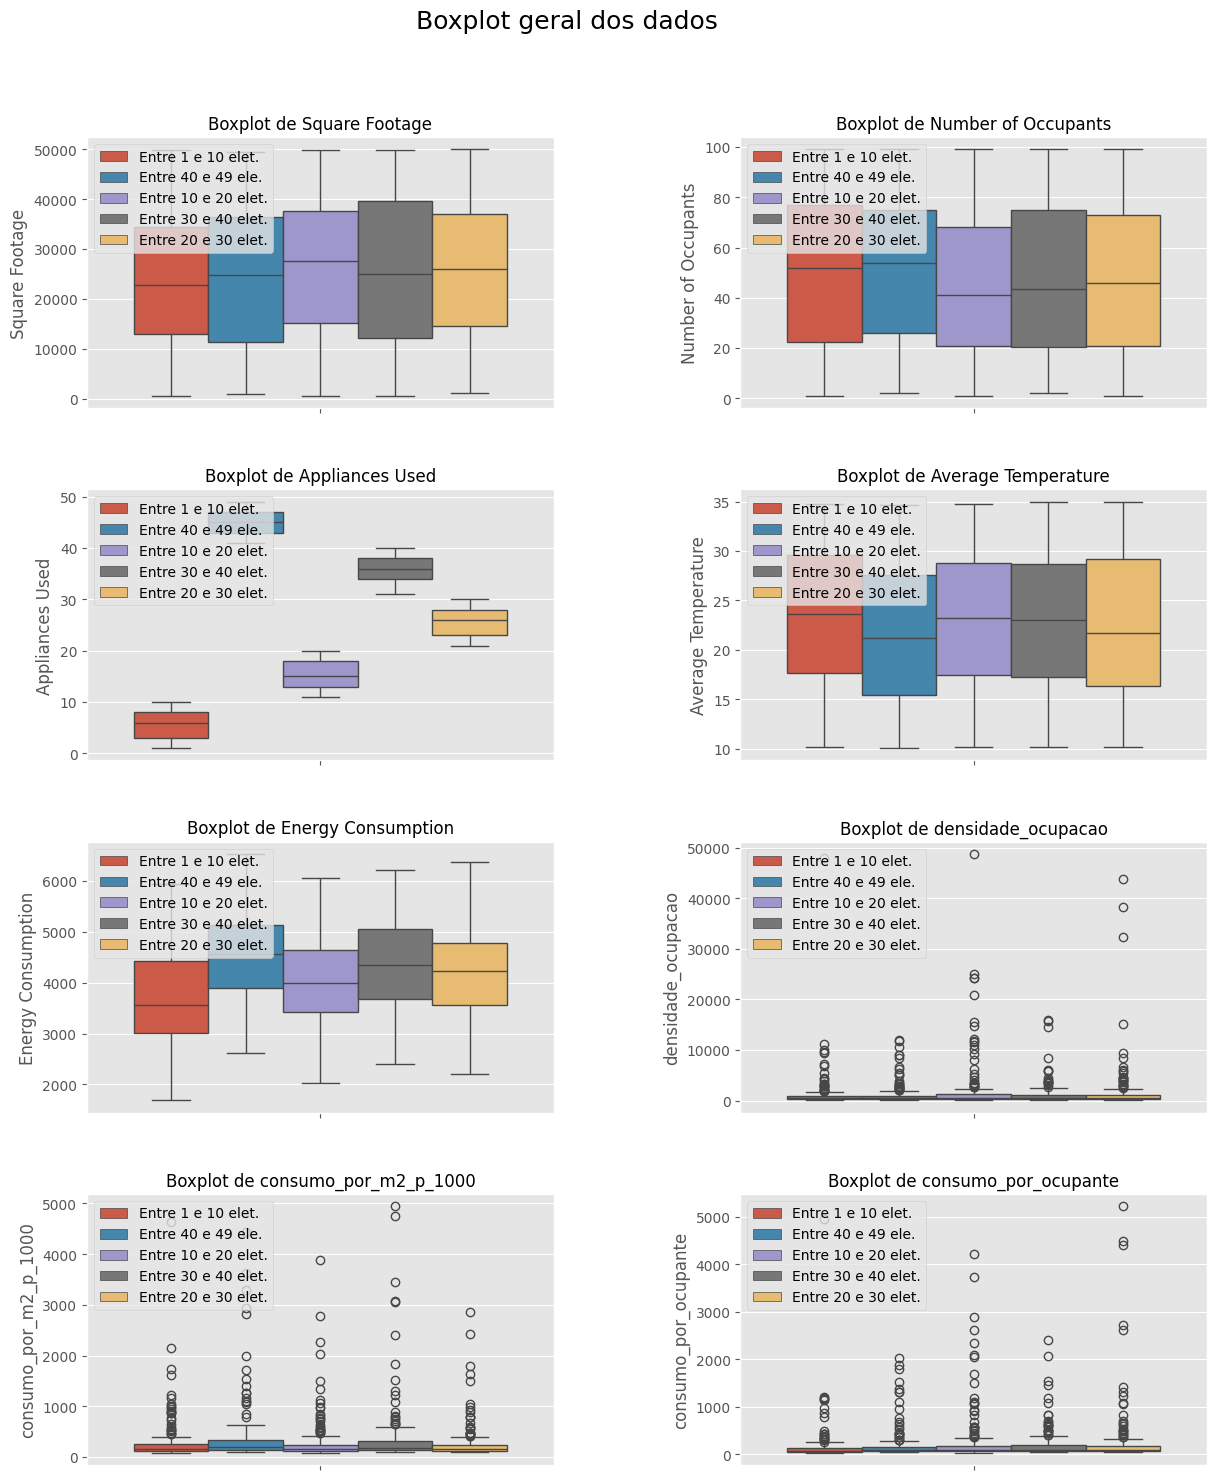

In [25]:

num_cols = 2
num_rows = 4



fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 4 * num_rows))
plt.suptitle('Boxplot geral dos dados', fontsize=18, y=1.01,x=0.4)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.boxplot(y=data[col], ax=ax, hue= data['Faixa_eletros'])
    ax.set_title(f'Boxplot de {col}', fontsize=12)
    ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show();

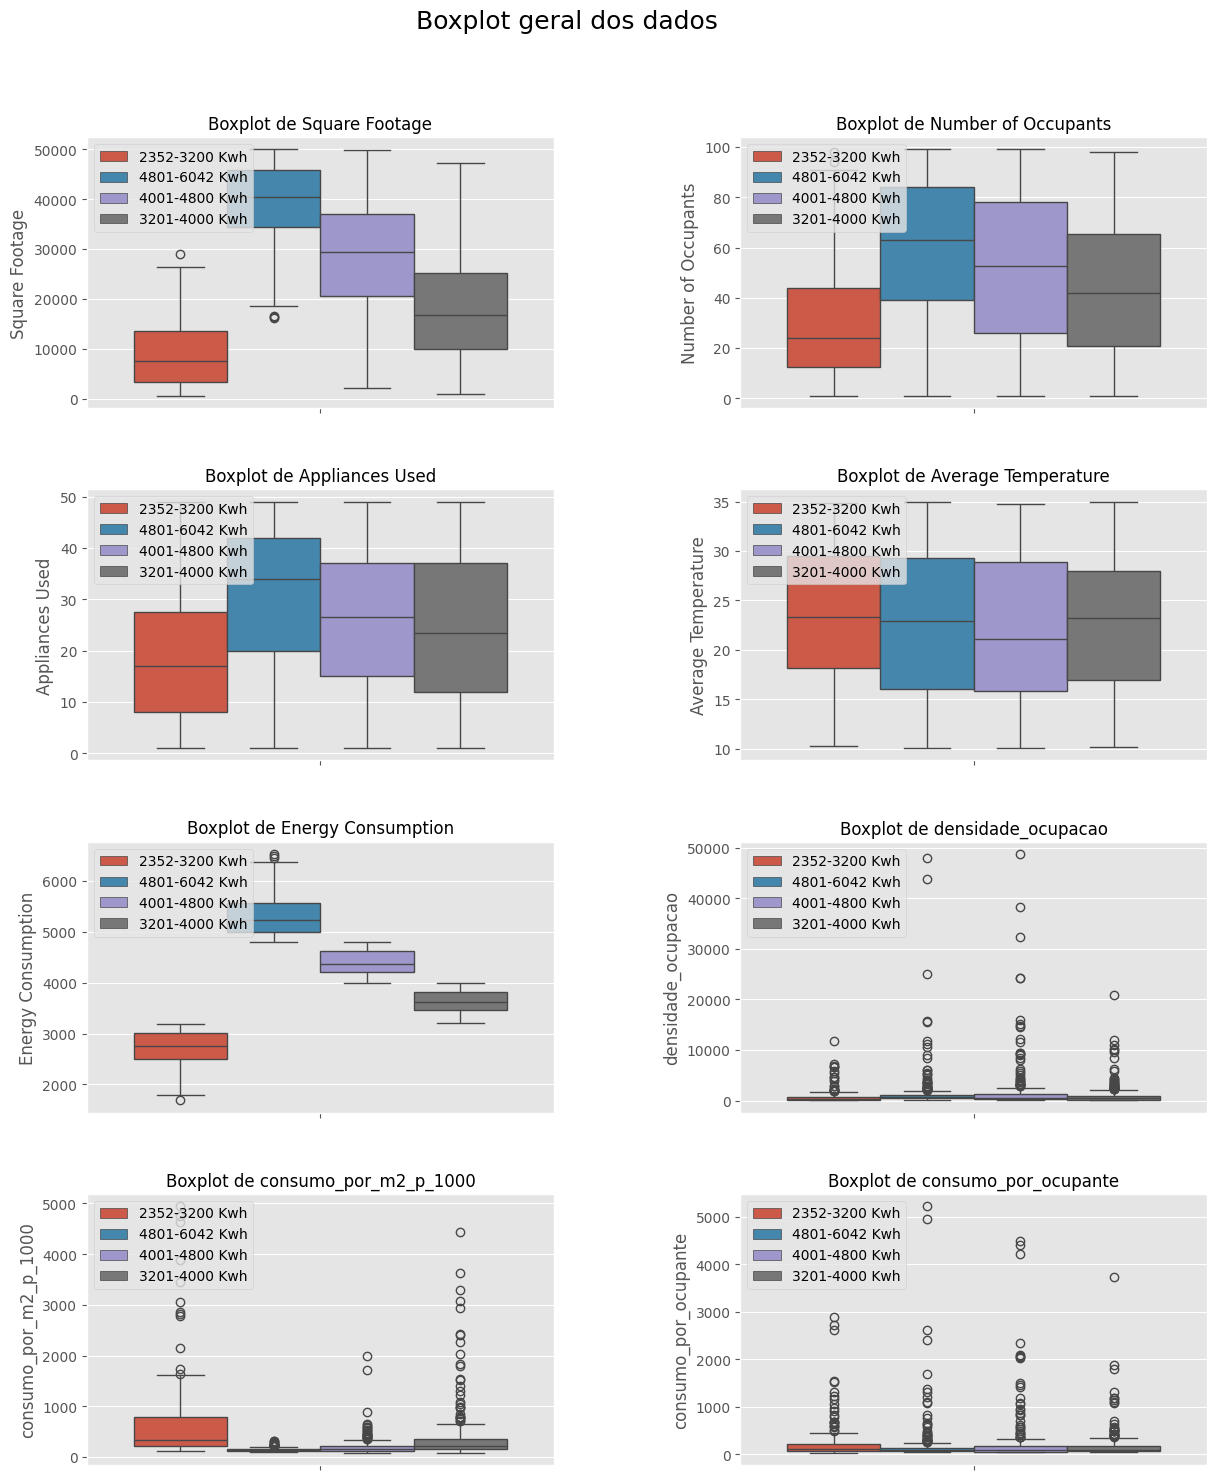

In [26]:

num_cols = 2
num_rows = 4



fig, axes = plt.subplots(num_rows, num_cols, figsize=(8 * num_cols, 4 * num_rows))
plt.suptitle('Boxplot geral dos dados', fontsize=18, y=1.01,x=0.4)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.boxplot(y=data[col], ax=ax, hue= data['Faixa_consumo'])
    ax.set_title(f'Boxplot de {col}', fontsize=12)
    ax.legend(loc='upper left')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show();

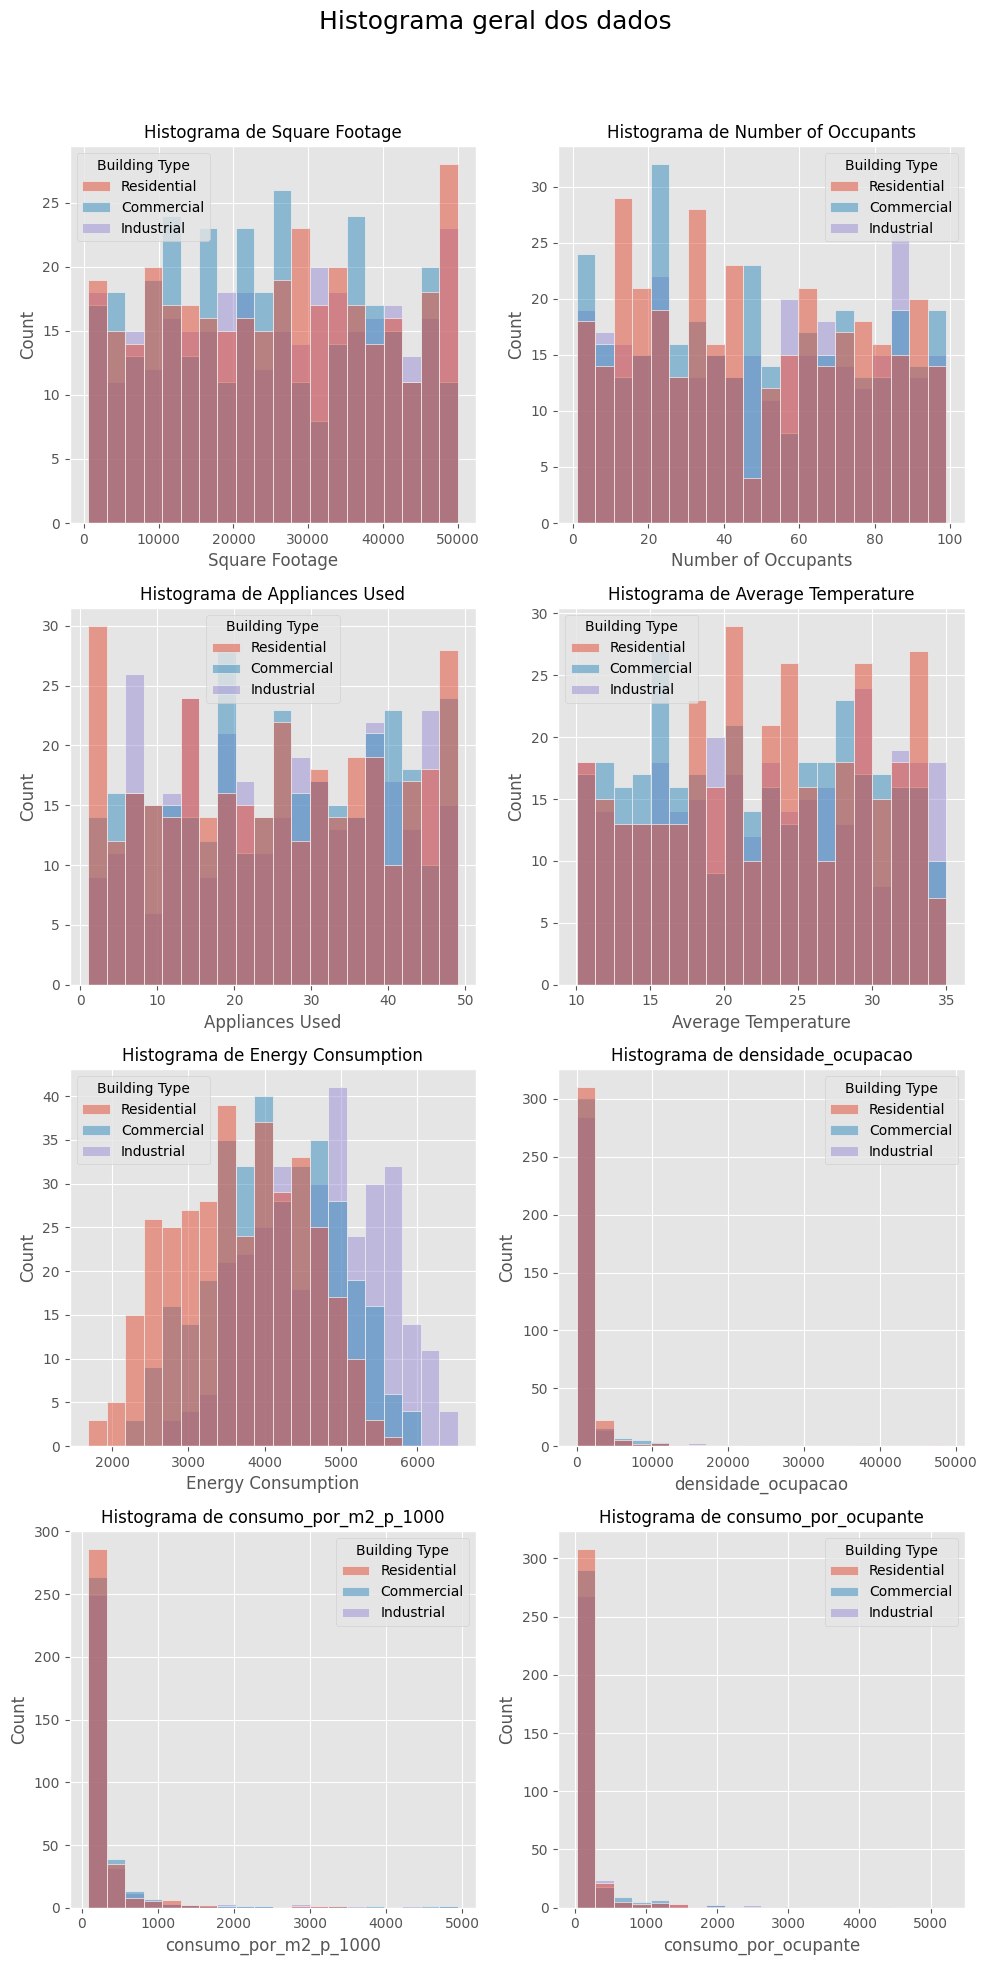

In [27]:
num_cols = 2
num_rows = 4


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

plt.suptitle('Histograma geral dos dados', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.histplot(data=data, x=col, hue="Building Type", bins=20, ax=ax)
    ax.set_title(f'Histograma de {col}', fontsize=12)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()

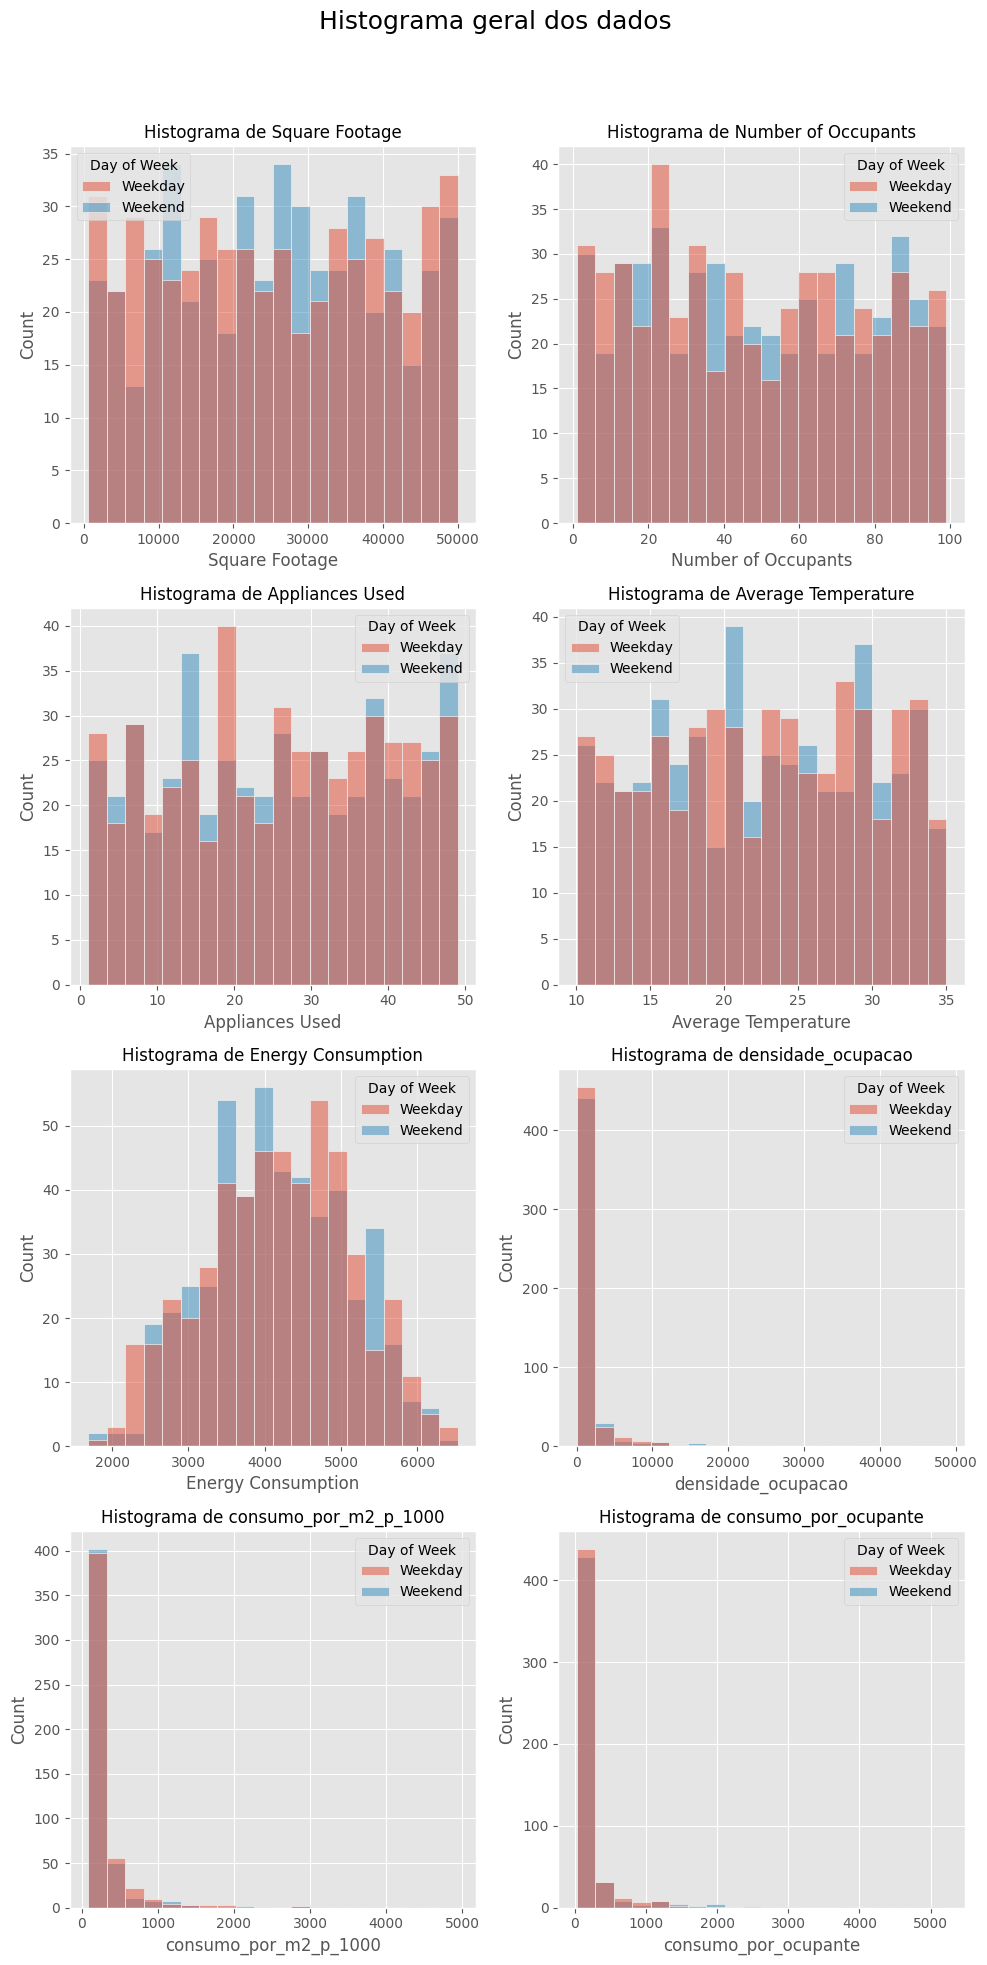

In [28]:
num_cols = 2
num_rows = 4


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

plt.suptitle('Histograma geral dos dados', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.histplot(data=data, x=col, hue="Day of Week", bins=20, ax=ax)
    ax.set_title(f'Histograma de {col}', fontsize=12)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()

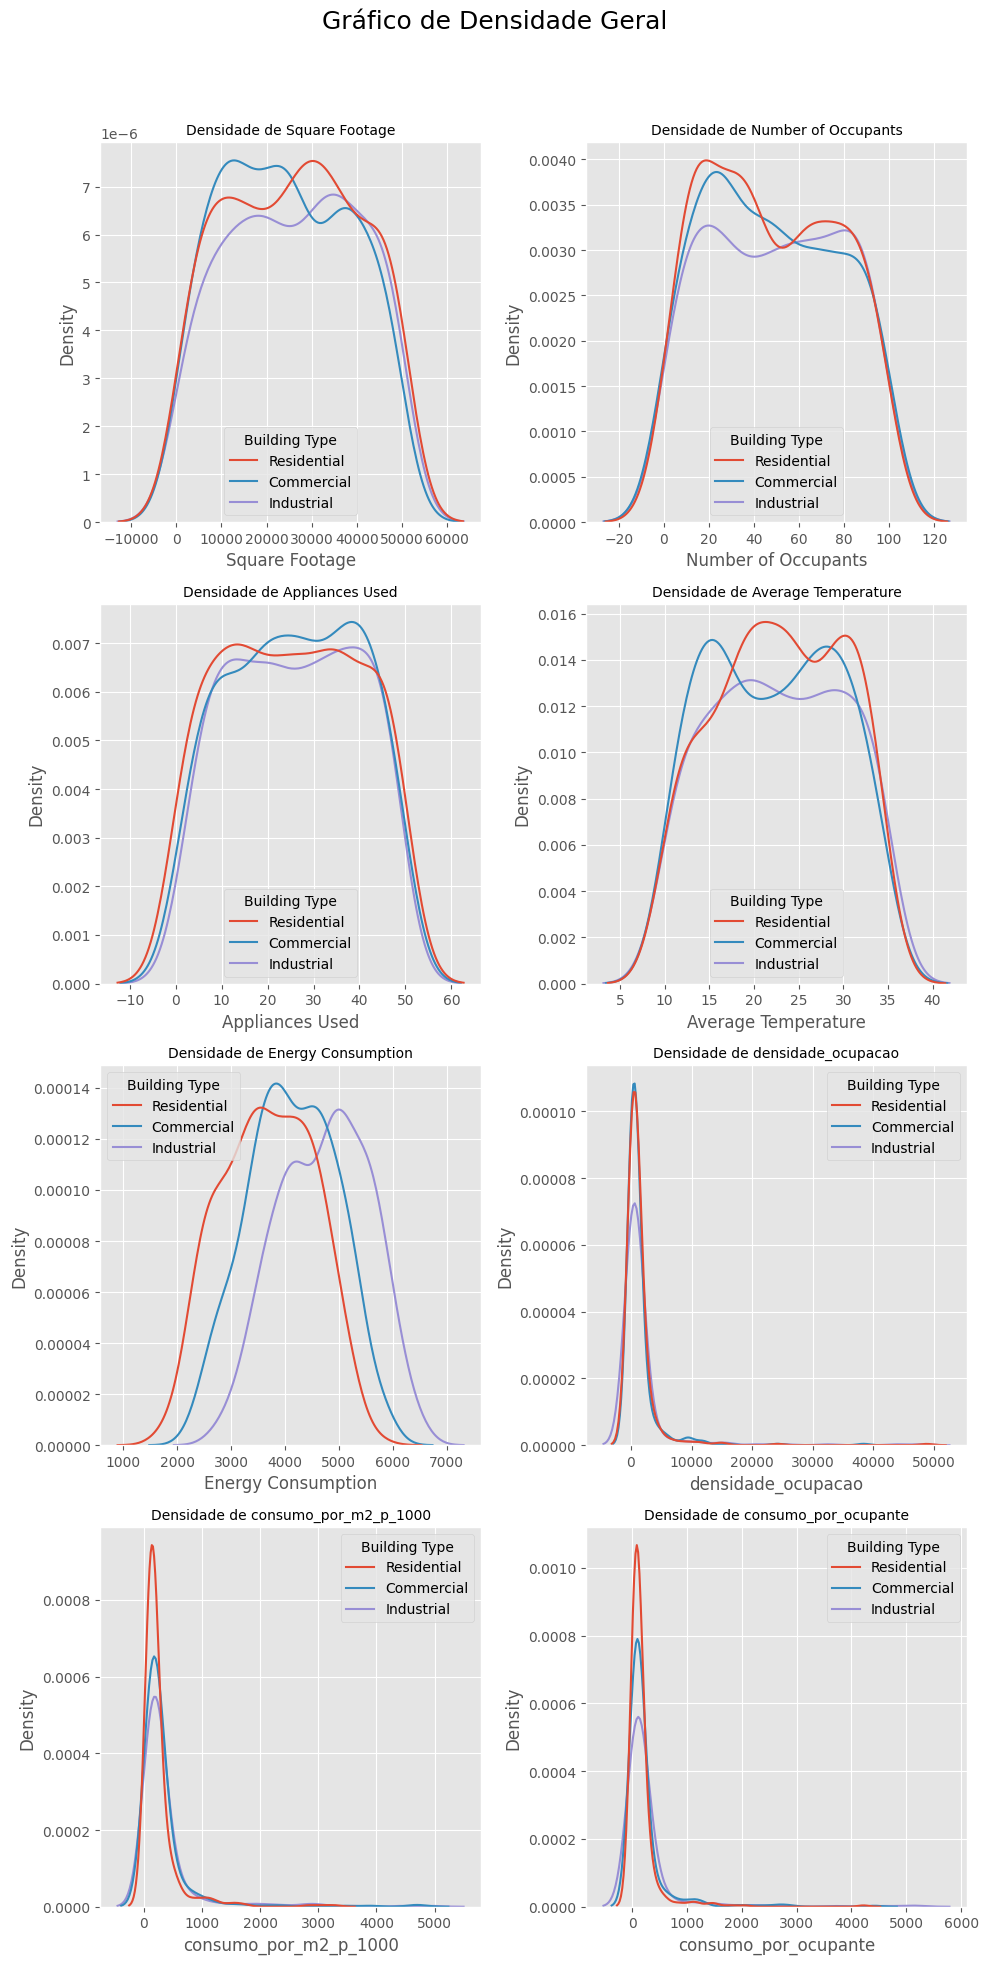

In [29]:

num_cols = 2
num_rows = 4


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

plt.suptitle('Gráfico de Densidade Geral', fontsize=18)


axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.kdeplot(data=data, x=col, hue='Building Type', ax=ax)
    ax.set_title(f'Densidade de {col}', fontsize=10)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()


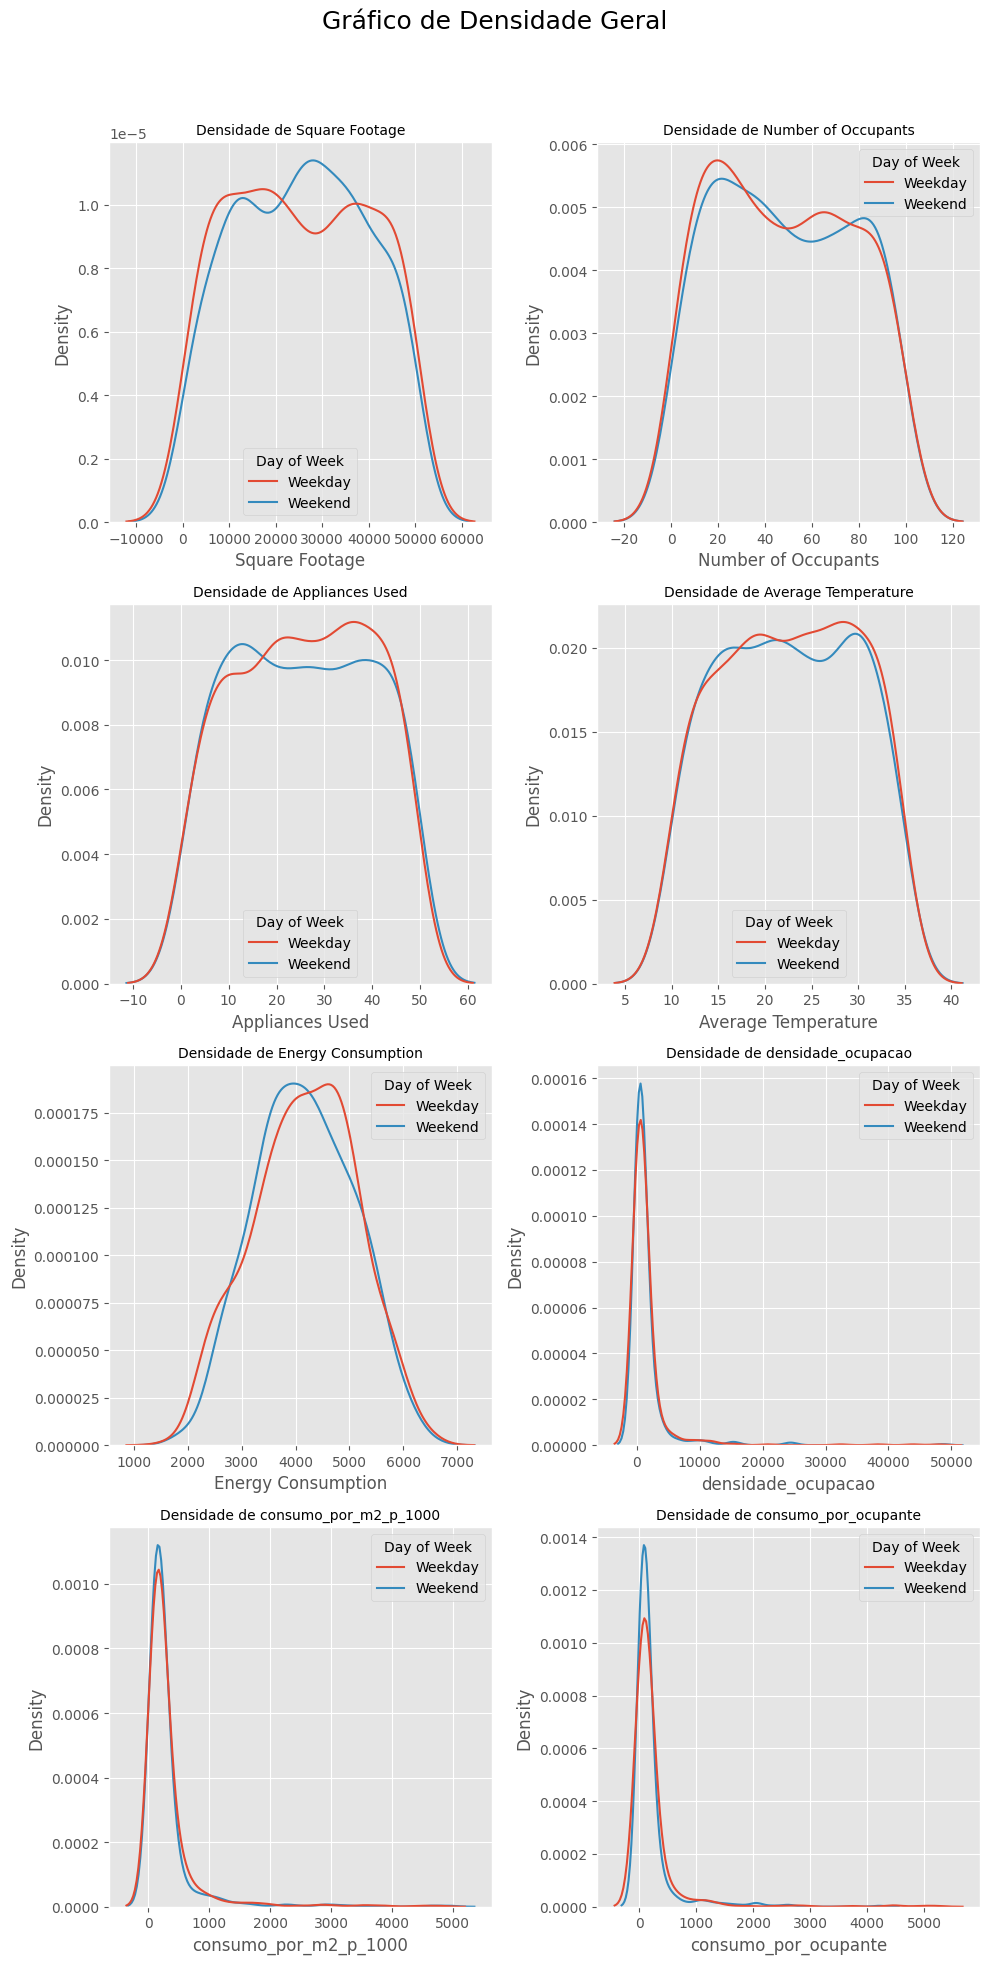

In [30]:

num_cols = 2
num_rows = 4


fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

plt.suptitle('Gráfico de Densidade Geral', fontsize=18)


axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.kdeplot(data=data, x=col, hue='Day of Week', ax=ax)
    ax.set_title(f'Densidade de {col}', fontsize=10)

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.tight_layout(rect=[0, 0, 1, 0.95])


plt.show()


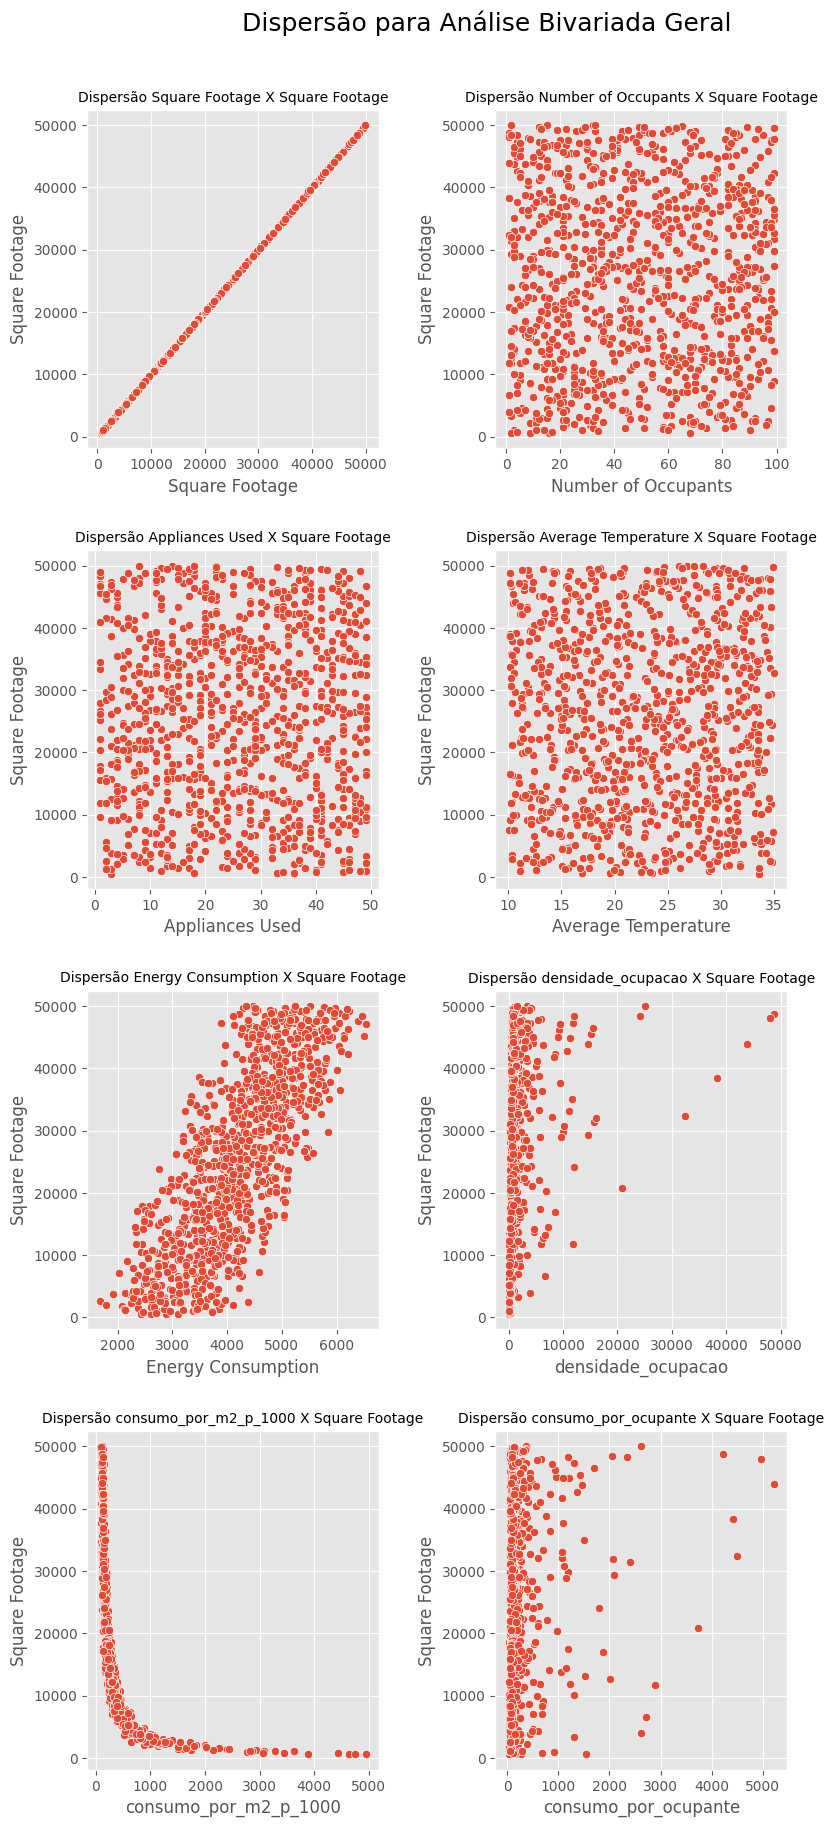

In [31]:
num_cols = 2
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

fig.suptitle('Dispersão para Análise Bivariada Geral', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.scatterplot(x=data[col],y=data['Square Footage'], ax=ax)
    ax.set_title("Dispersão {} X Square Footage".format(col), fontsize=10)
    plt.xlabel(col)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show()

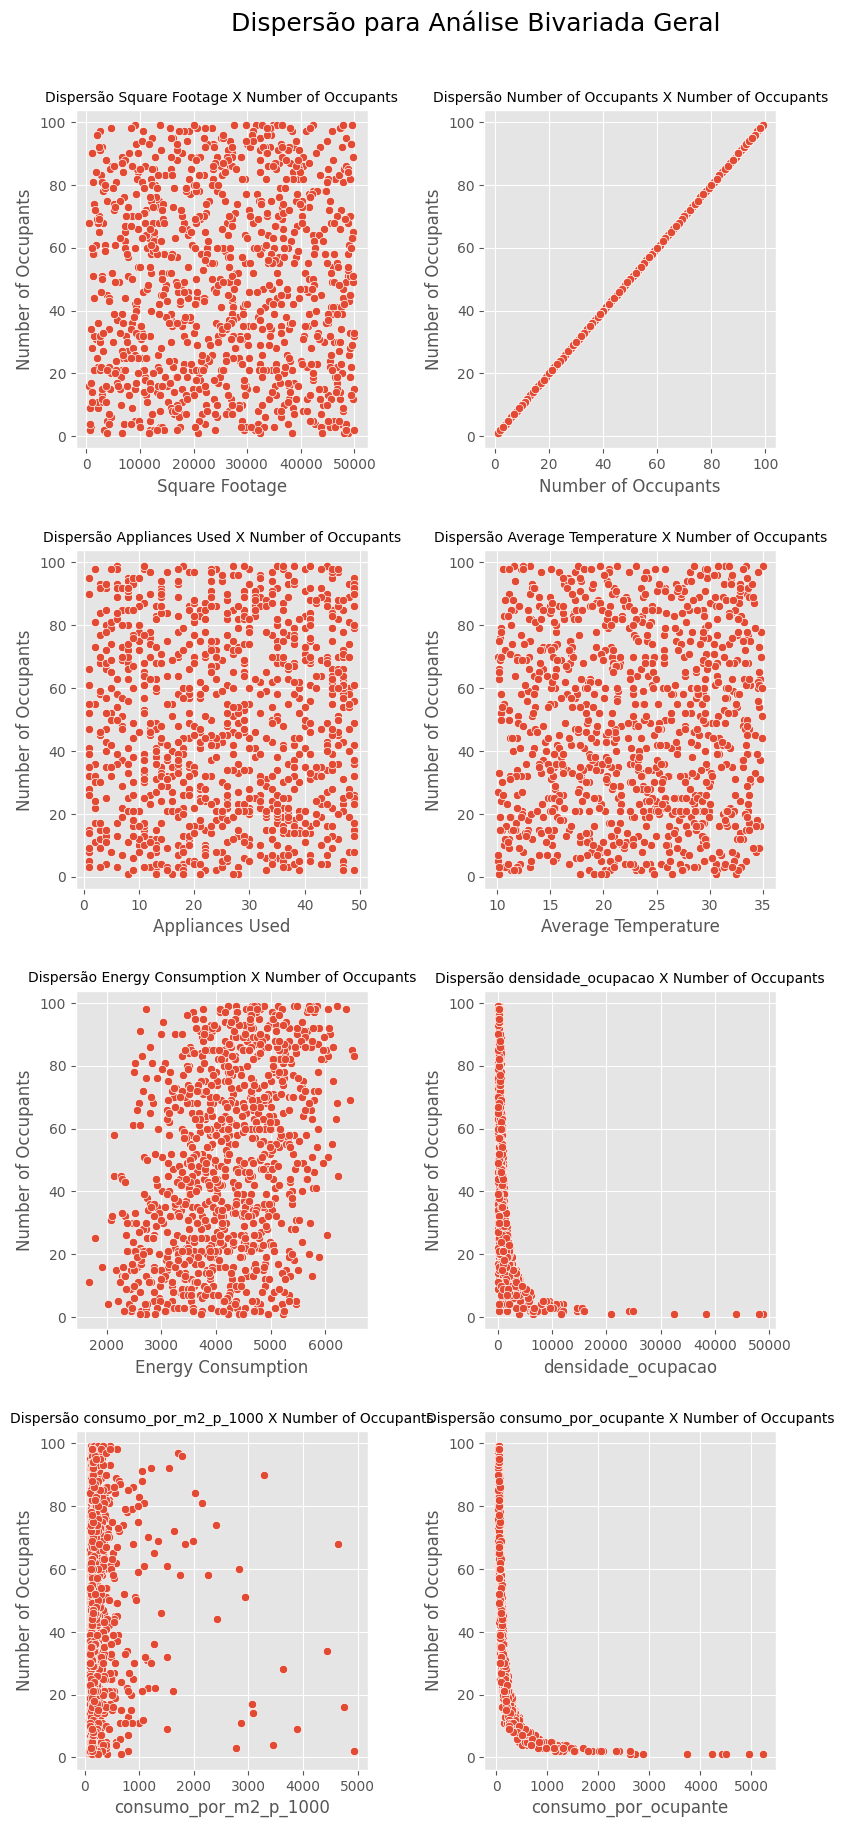

In [32]:
num_cols = 2
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

fig.suptitle('Dispersão para Análise Bivariada Geral', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.scatterplot(x=data[col],y=data['Number of Occupants'], ax=ax)
    ax.set_title("Dispersão {} X Number of Occupants".format(col), fontsize=10)
    plt.xlabel(col)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show()

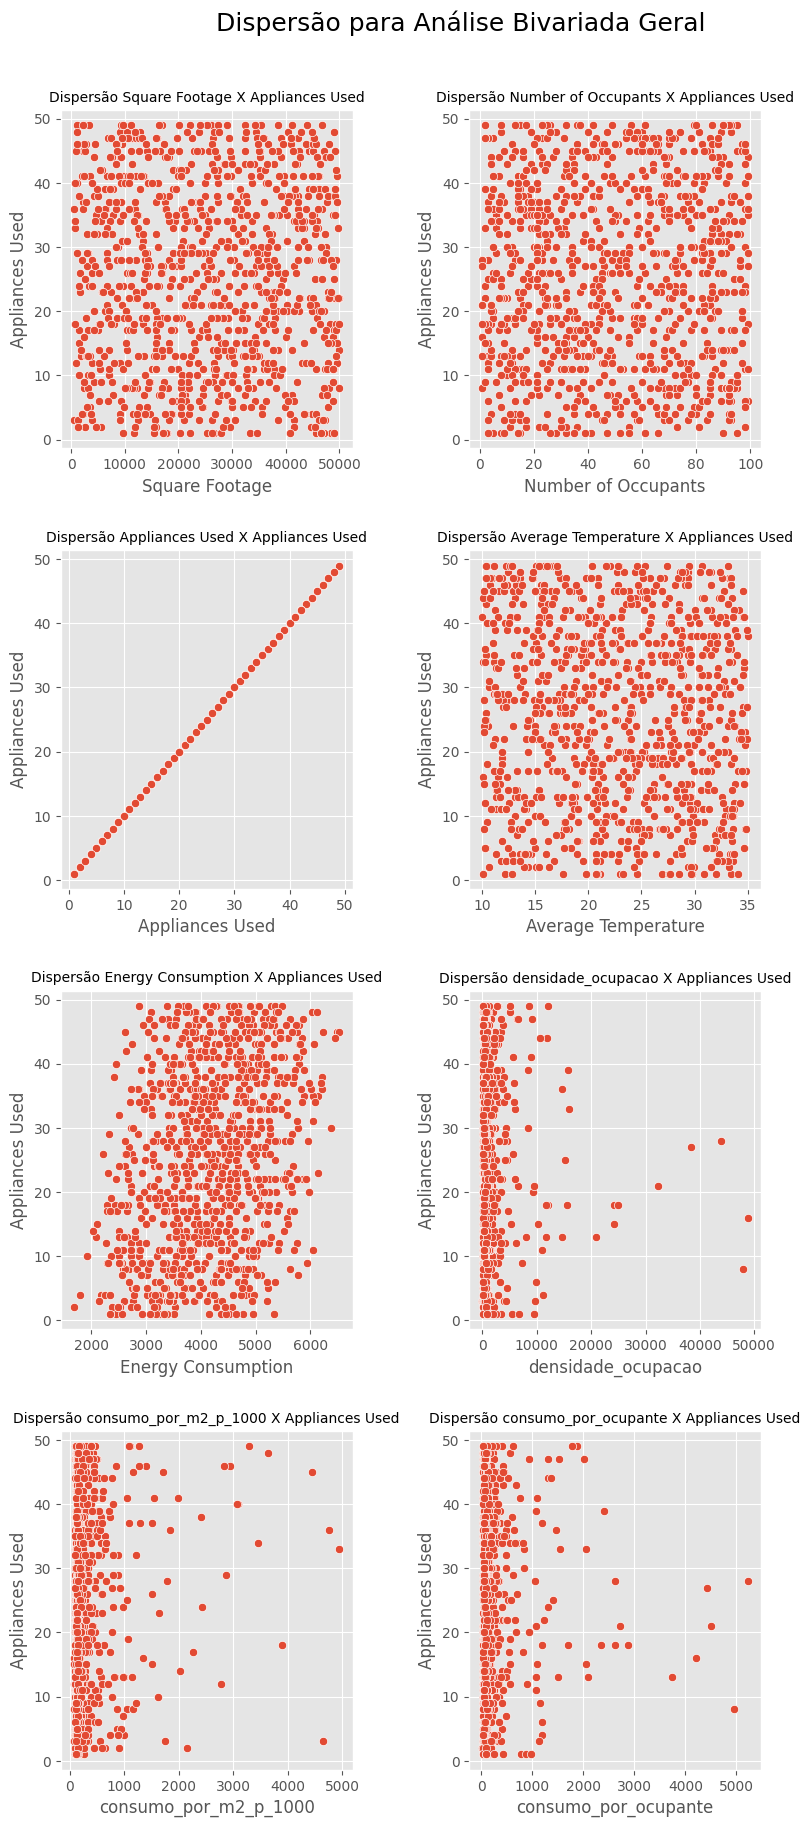

In [33]:
num_cols = 2
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

fig.suptitle('Dispersão para Análise Bivariada Geral', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.scatterplot(x=data[col],y=data['Appliances Used'], ax=ax)
    ax.set_title("Dispersão {} X Appliances Used".format(col), fontsize=10)
    plt.xlabel(col)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show()

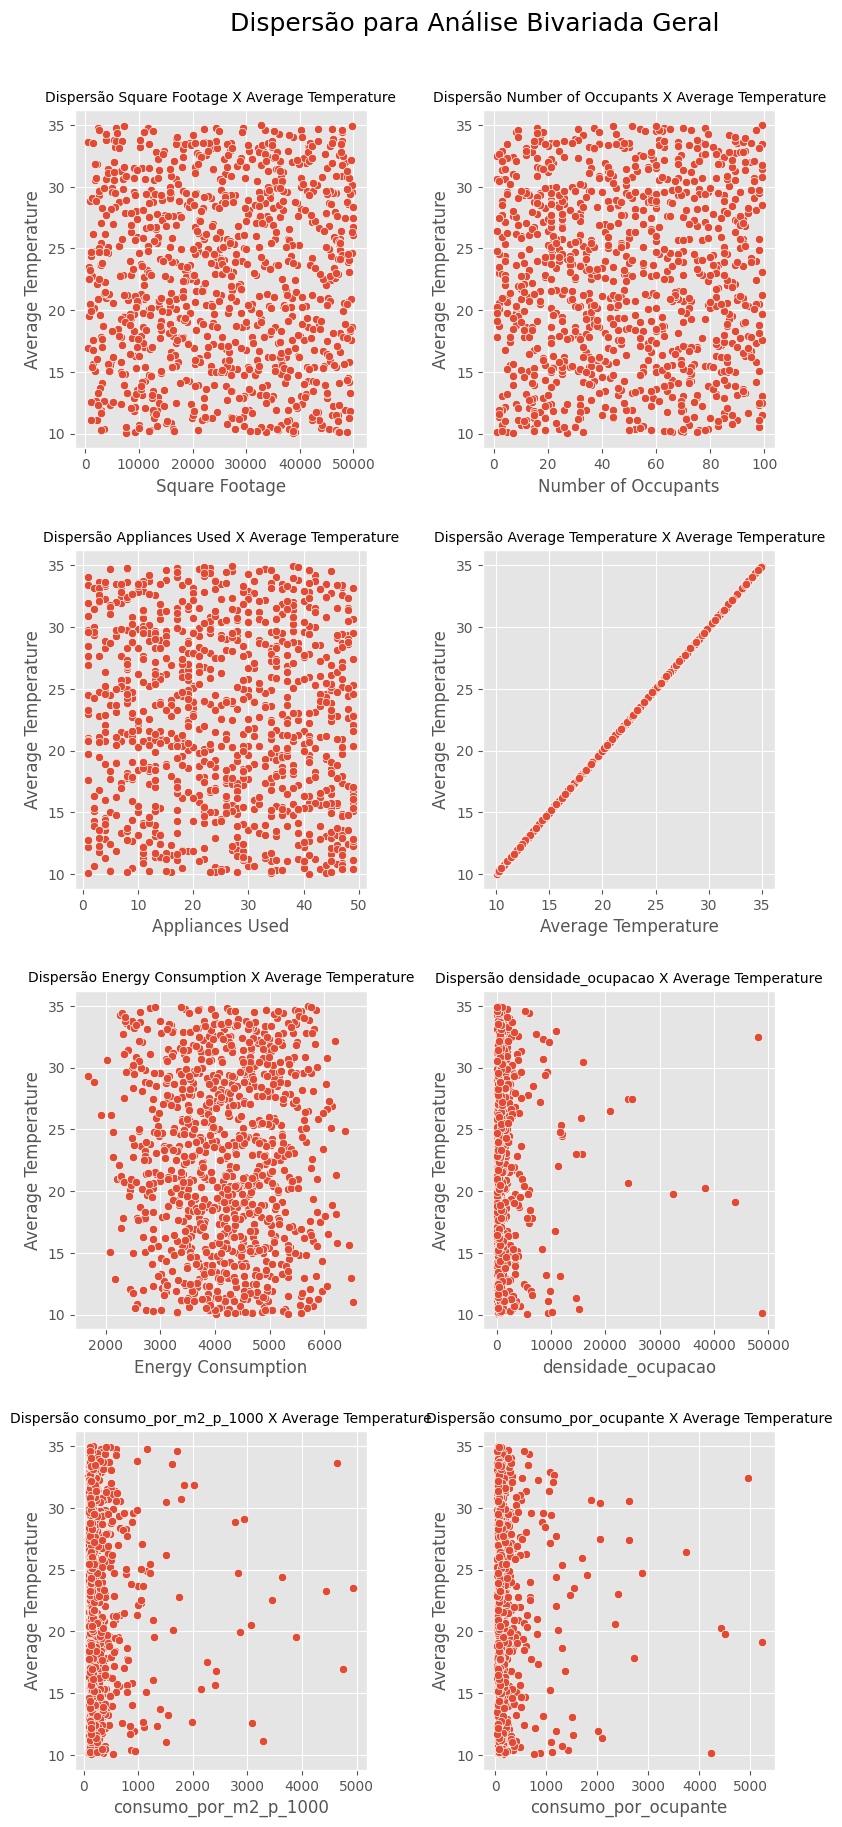

In [34]:
num_cols = 2
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

fig.suptitle('Dispersão para Análise Bivariada Geral', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.scatterplot(x=data[col],y=data['Average Temperature'], ax=ax)
    ax.set_title("Dispersão {} X Average Temperature".format(col), fontsize=10)
    plt.xlabel(col)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show()

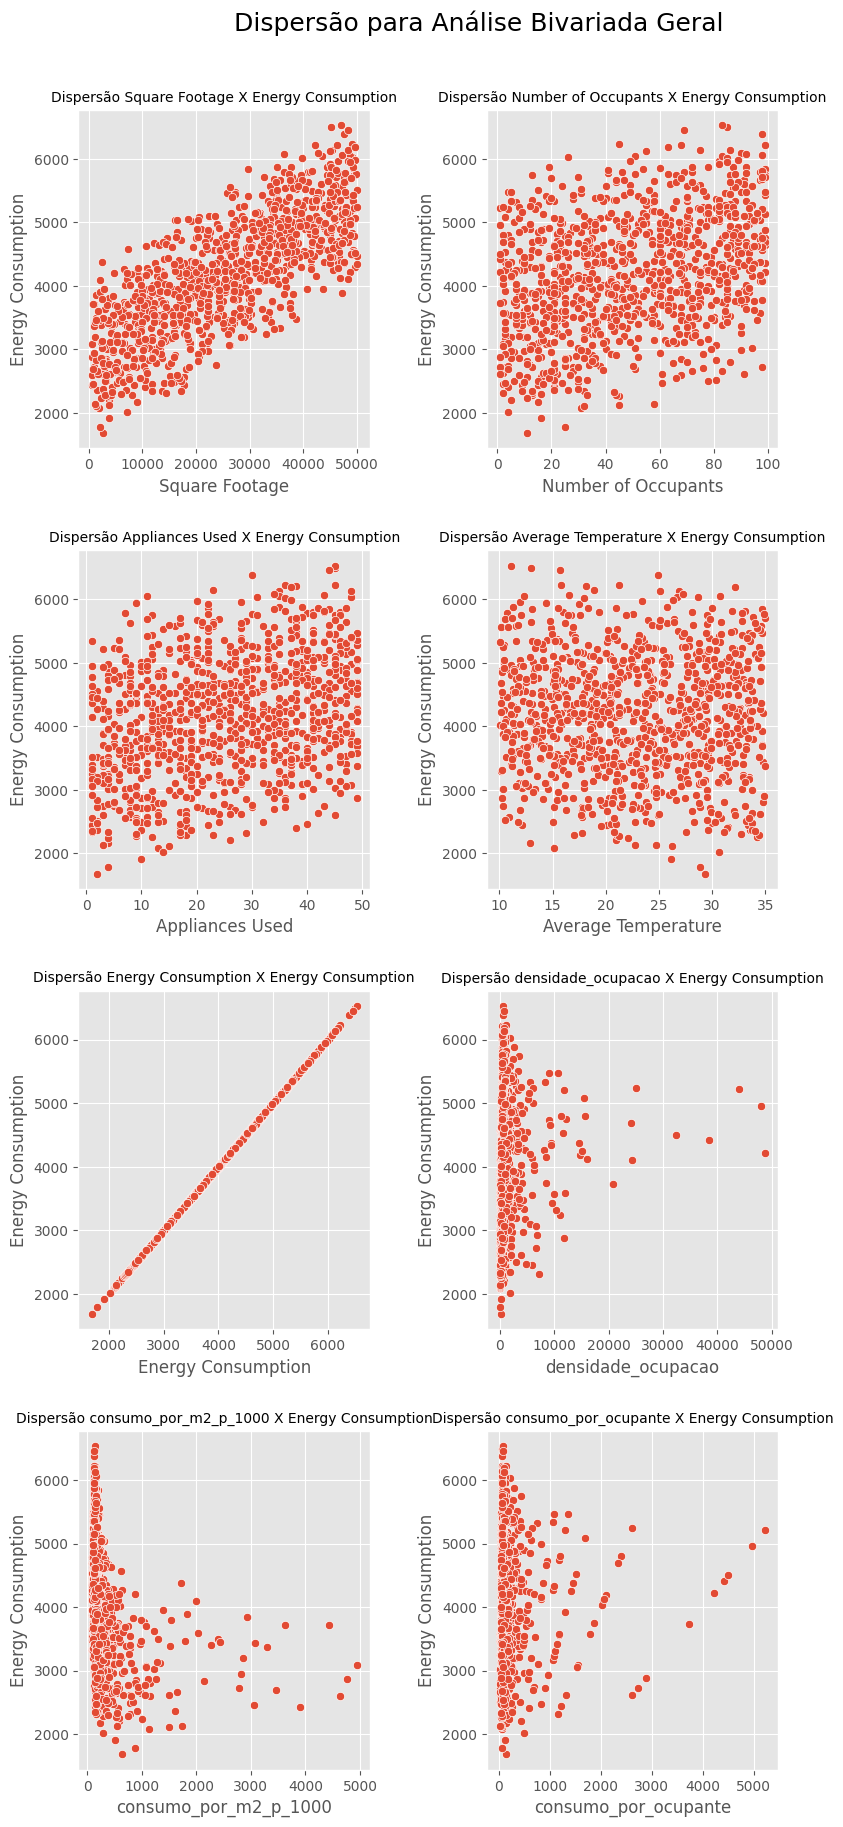

In [35]:
num_cols = 2
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

fig.suptitle('Dispersão para Análise Bivariada Geral', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.scatterplot(x=data[col],y=data['Energy Consumption'], ax=ax)
    ax.set_title("Dispersão {} X Energy Consumption".format(col), fontsize=10)
    plt.xlabel(col)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show()

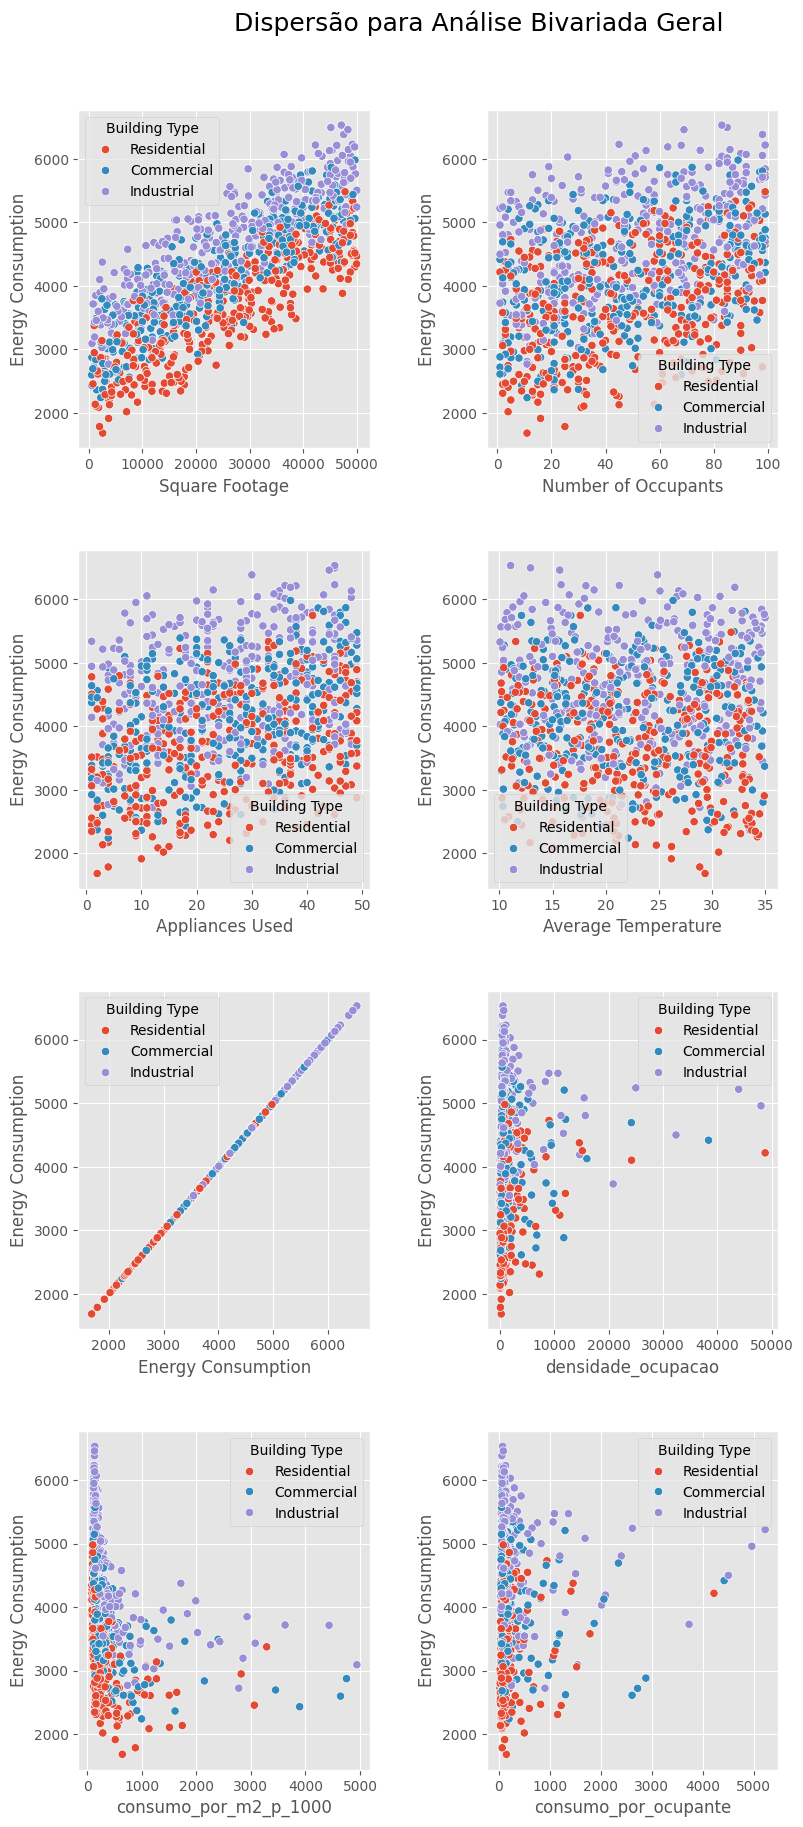

In [36]:
num_cols = 2
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

fig.suptitle('Dispersão para Análise Bivariada Geral', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.scatterplot(
        data=data,
        x=col,
        y='Energy Consumption',
        hue='Building Type',
        ax=ax
    )


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show()

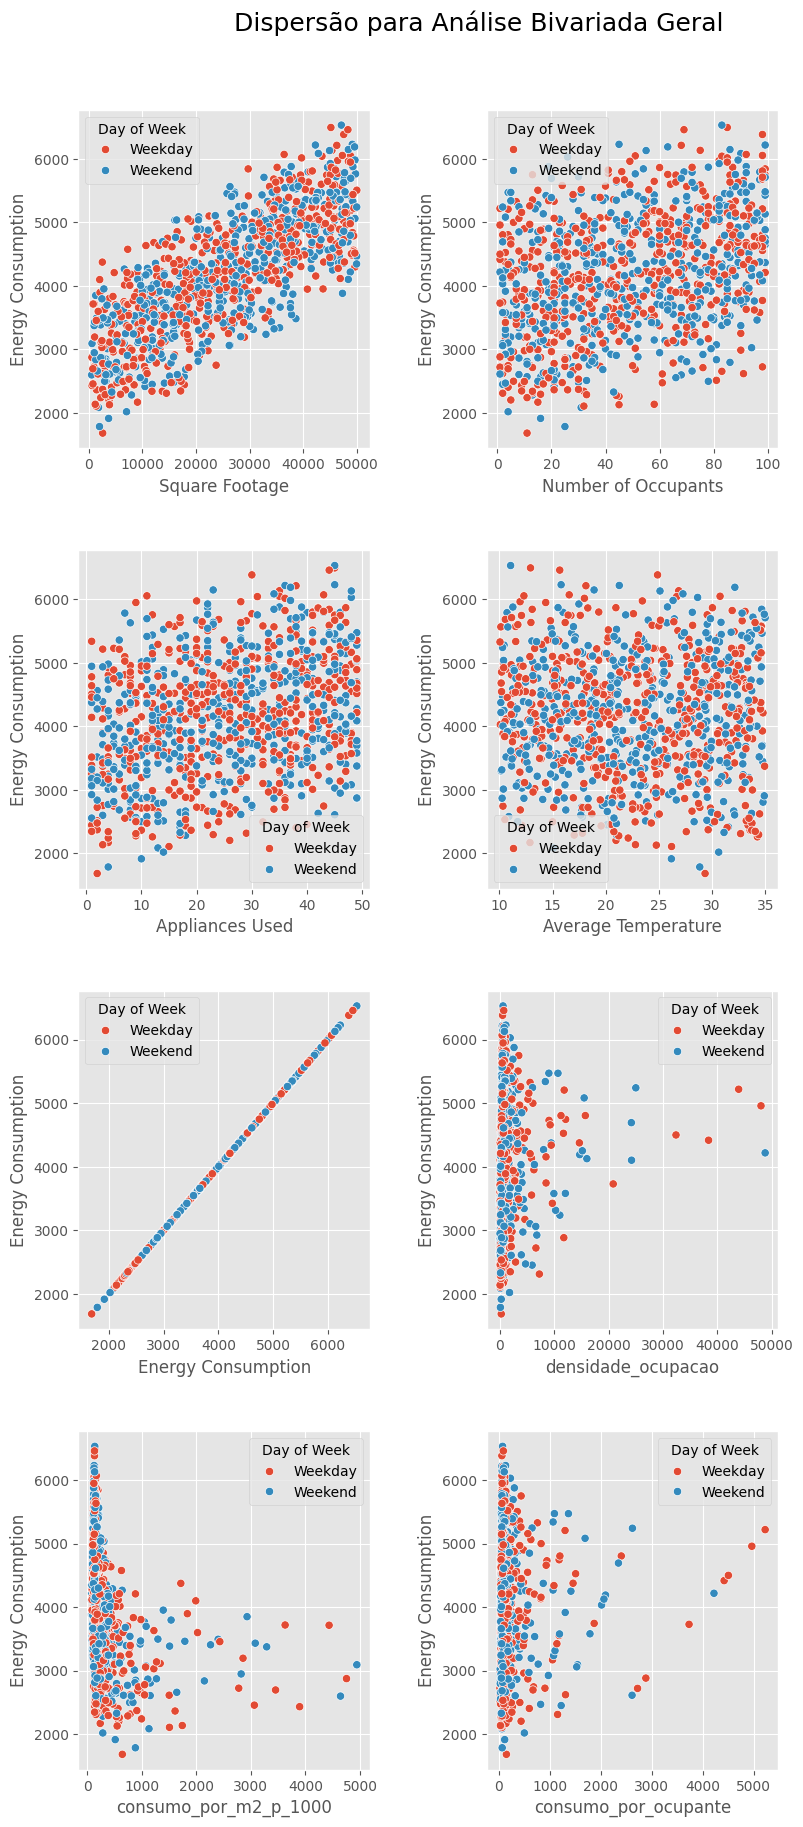

In [37]:
num_cols = 2
num_rows = 4

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 5 * num_rows))

fig.suptitle('Dispersão para Análise Bivariada Geral', fontsize=18)

axes = axes.flatten()

for ax, col in zip(axes, lista):
    sns.scatterplot(
        data=data,
        x=col,
        y='Energy Consumption',
        hue='Day of Week',
        ax=ax
    )


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.8, top=0.93, wspace=0.4, hspace=0.3)

plt.show()

###Análise Multivariada

In [38]:
fig = px.scatter(data, x = 'Square Footage', y = 'Energy Consumption',
                 size = 'Number of Occupants', color = 'Building Type')
fig.show()

In [39]:
fig = px.scatter(data, x = 'Square Footage', y = 'Energy Consumption',
                 size = 'Number of Occupants', color = 'Day of Week')
fig.show()

In [40]:
fig = px.scatter(data, x = 'Square Footage', y = 'Energy Consumption',
                 size = 'Appliances Used', color = 'Building Type')
fig.show()

In [41]:
fig = px.scatter(data, x = 'Square Footage', y = 'Energy Consumption',
                 size = 'Appliances Used', color = 'Day of Week')
fig.show()

##Relatório Técnico

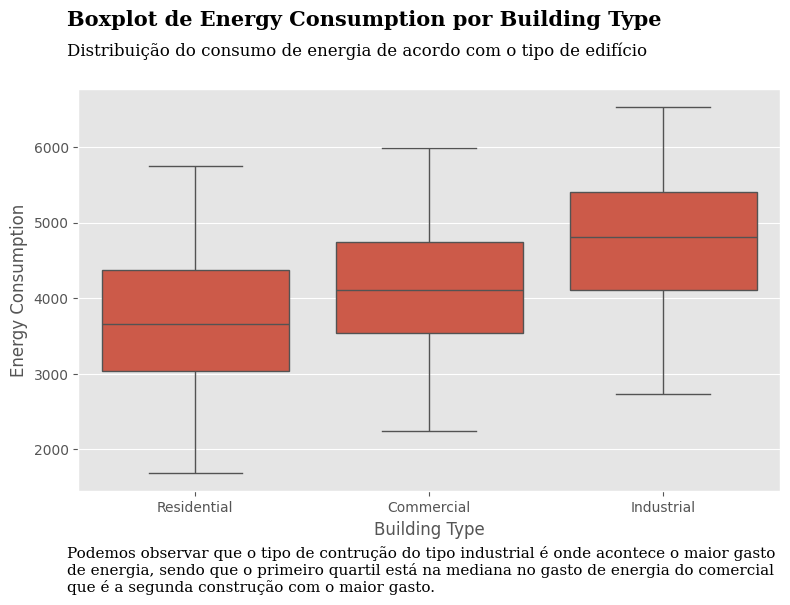

In [42]:

fig, ax = plt.subplots(figsize=(8, 6))

fig.text(
    0.09, 0.96,
    'Boxplot de Energy Consumption por Building Type',
    fontsize=15, fontweight='bold', fontfamily='serif'
)

fig.text(
    0.09, 0.91,
    'Distribuição do consumo de energia de acordo com o tipo de edifício',
    fontsize=12, fontweight='light', fontfamily='serif'
)

sns.boxplot(
    y=data['Energy Consumption'],
    x=data['Building Type'],
    ax=ax
)

fig.text(
    0.09, 0.02,
    '''Podemos observar que o tipo de contrução do tipo industrial é onde acontece o maior gasto de energia, sendo que o primeiro quartil está na mediana no gasto de energia do comercial que é a segunda construção com o maior gasto.''',
    fontsize=11,
    fontfamily='serif',
    wrap=True
)

plt.tight_layout(rect=[0, 0.08, 1, 0.88])

plt.show()

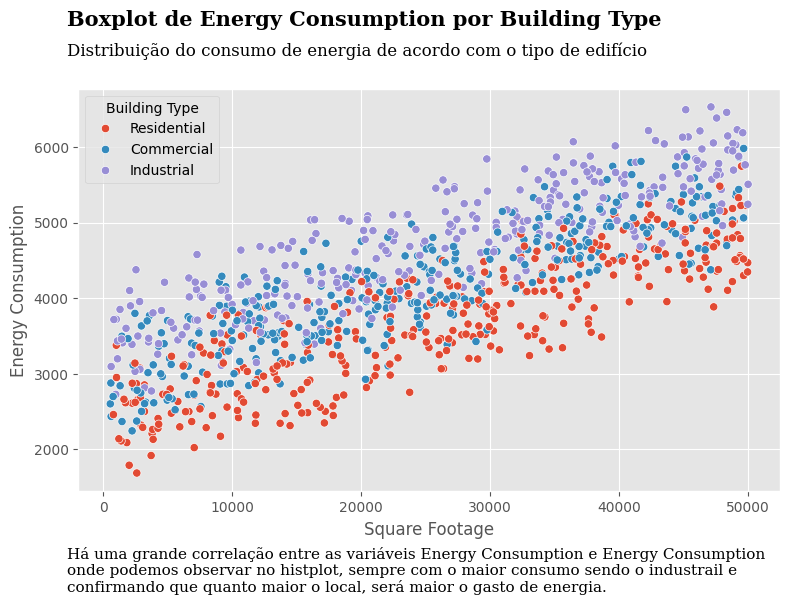

In [43]:
# Criação da figura
fig, ax = plt.subplots(figsize=(8, 6))

# Título e subtítulo
fig.text(
    0.09, 0.96,
    'Boxplot de Energy Consumption por Building Type',
    fontsize=15, fontweight='bold', fontfamily='serif'
)

fig.text(
    0.09, 0.91,
    'Distribuição do consumo de energia de acordo com o tipo de edifício',
    fontsize=12, fontweight='light', fontfamily='serif'
)


# Boxplot
sns.scatterplot(
        data=data,
        x='Square Footage',
        y='Energy Consumption',
        hue='Building Type',
        ax=ax
    )


# Texto explicativo (fora do gráfico)
fig.text(
    0.09, 0.02,
    '''Há uma grande correlação entre as variáveis Energy Consumption e Energy Consumption onde podemos observar no histplot, sempre com o maior consumo sendo o industrail e confirmando que quanto maior o local, será maior o gasto de energia.''',
    fontsize=11,
    fontfamily='serif',
    wrap=True
)


plt.tight_layout(rect=[0, 0.08, 1, 0.88])

plt.show()


##Modelagem

In [44]:
data.head()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
0   Residential            7063                   76               10   
1    Commercial           44372                   66               45   
2    Industrial           19255                   37               17   
3   Residential           13265                   14               41   
4    Commercial           13375                   26               18   

   Average Temperature Day of Week  Energy Consumption  densidade_ocupacao  \
0                29.84     Weekday             2713.95                93.0   
1                16.72     Weekday             5744.99               672.0   
2                14.30     Weekend             4101.24               520.0   
3                32.82     Weekday             3009.14               948.0   
4                11.92     Weekday             3279.17               514.0   

   consumo_por_m2_p_1000  consumo_por_ocupante      Faixa_ocupantes  \
0                  384.0                  36.0        Entre 75 e 99   
1                  129.0                  87.0  Entre 51 e 75 Ocup.   
2                  213.0                 111.0  Entre 26 e 50 Ocup.   
3                  227.0                 215.0   Entre 1 e 25 Ocup.   
4                  245.0                 126.0  Entre 26 e 50 Ocup.   

         Faixa_eletros  Faixa_consumo  
0   Entre 1 e 10 elet.  2352-3200 Kwh  
1   Entre 40 e 49 ele.  4801-6042 Kwh  
2  Entre 10 e 20 elet.  4001-4800 Kwh  
3   Entre 40 e 49 ele.  2352-3200 Kwh  
4  Entre 10 e 20 elet.  3201-4000 Kwh

###Preparação de dados

In [45]:
N_data = data.drop(['consumo_por_m2_p_1000',	'consumo_por_ocupante', 'Faixa_ocupantes',	'Faixa_eletros', 'Faixa_consumo' ], axis=1)

In [46]:
N_data.head()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
0   Residential            7063                   76               10   
1    Commercial           44372                   66               45   
2    Industrial           19255                   37               17   
3   Residential           13265                   14               41   
4    Commercial           13375                   26               18   

   Average Temperature Day of Week  Energy Consumption  densidade_ocupacao  
0                29.84     Weekday             2713.95                93.0  
1                16.72     Weekday             5744.99               672.0  
2                14.30     Weekend             4101.24               520.0  
3                32.82     Weekday             3009.14               948.0  
4                11.92     Weekday             3279.17               514.0

In [47]:
N_data['Building Type'] = N_data['Building Type'].map({'Residential': 0, 'Commercial': 1, 'Industrial':2 })
N_data['Day of Week'] = N_data['Day of Week'].map({'Weekday': 0, 'Weekend': 1})
N_data.head()

Building Type  Square Footage  Number of Occupants  Appliances Used  \
0              0            7063                   76               10   
1              1           44372                   66               45   
2              2           19255                   37               17   
3              0           13265                   14               41   
4              1           13375                   26               18   

   Average Temperature  Day of Week  Energy Consumption  densidade_ocupacao  
0                29.84            0             2713.95                93.0  
1                16.72            0             5744.99               672.0  
2                14.30            1             4101.24               520.0  
3                32.82            0             3009.14               948.0  
4                11.92            0             3279.17               514.0

In [48]:
teste =  N_data.drop(['Building Type', 'Day of Week' ], axis=1)
teste.head()

Square Footage  Number of Occupants  Appliances Used  Average Temperature  \
0            7063                   76               10                29.84   
1           44372                   66               45                16.72   
2           19255                   37               17                14.30   
3           13265                   14               41                32.82   
4           13375                   26               18                11.92   

   Energy Consumption  densidade_ocupacao  
0             2713.95                93.0  
1             5744.99               672.0  
2             4101.24               520.0  
3             3009.14               948.0  
4             3279.17               514.0

Teste de Correlação

> Adicionar aspas



In [49]:
teste.corr()

Square Footage  Number of Occupants  Appliances Used  \
Square Footage             1.000000             0.033379        -0.013478   
Number of Occupants        0.033379             1.000000         0.023646   
Appliances Used           -0.013478             0.023646         1.000000   
Average Temperature        0.027273             0.014122        -0.062870   
Energy Consumption         0.774873             0.354485         0.312792   
densidade_ocupacao         0.241308            -0.391825        -0.042151   

                     Average Temperature  Energy Consumption  \
Square Footage                  0.027273            0.774873   
Number of Occupants             0.014122            0.354485   
Appliances Used                -0.062870            0.312792   
Average Temperature             1.000000           -0.034487   
Energy Consumption             -0.034487            1.000000   
densidade_ocupacao             -0.021690            0.064770   

                     densidade_ocupacao  
Square Footage                 0.241308  
Number of Occupants           -0.391825  
Appliances Used               -0.042151  
Average Temperature           -0.021690  
Energy Consumption             0.064770  
densidade_ocupacao             1.000000

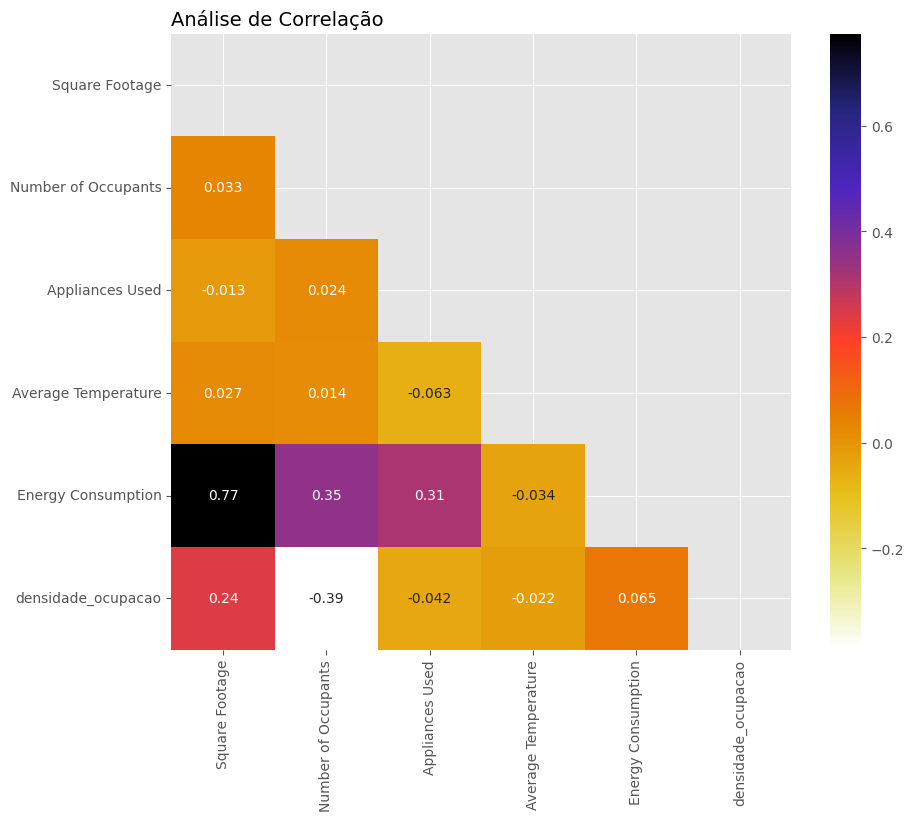

In [50]:
Figura, Eixo = plt.subplots( figsize=(10, 8) )

Correlacao = teste.corr()

mask = np.zeros_like( Correlacao )
mask[ np.triu_indices_from(mask) ] = True

plt.title('Análise de Correlação', loc='left', fontsize=14)

sns.heatmap(
    Correlacao,
    mask=mask,
    cmap='CMRmap_r',
    annot=True,
    );

In [51]:
Eixo_x = N_data.drop( columns=['Energy Consumption'] )
Eixo_y = N_data['Energy Consumption']

Teste de importância da variáveis com relação a variável dependente.

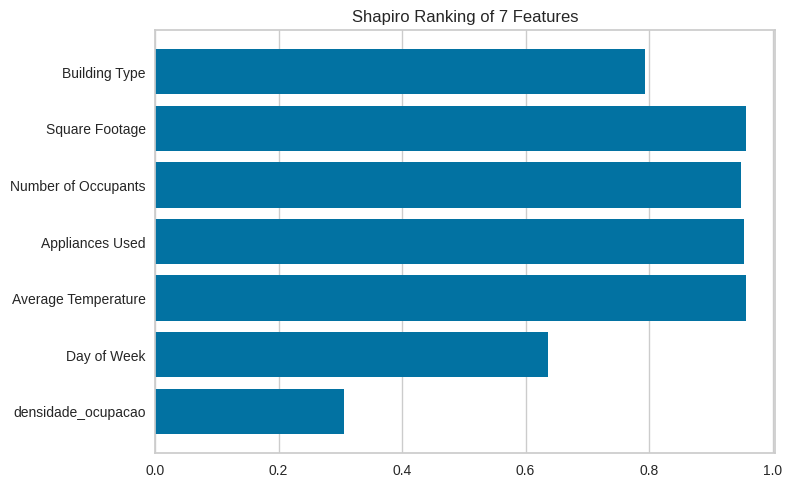

In [52]:
from yellowbrick.features import Rank1D
Viz_Shapiro = Rank1D( algorithm='shapiro' )
Viz_Shapiro.fit( Eixo_x, Eixo_y )
Viz_Shapiro.transform( Eixo_x )

Viz_Shapiro.show();

In [53]:
Eixo_x

Building Type  Square Footage  Number of Occupants  Appliances Used  \
0                0            7063                   76               10   
1                1           44372                   66               45   
2                2           19255                   37               17   
3                0           13265                   14               41   
4                1           13375                   26               18   
..             ...             ...                  ...              ...   
995              0           14419                   68               44   
996              2           12194                    7               22   
997              1           39562                   88               20   
998              0            8348                   67               37   
999              1           15813                   57               11   

     Average Temperature  Day of Week  densidade_ocupacao  
0                  29.84            0                93.0  
1                  16.72            0               672.0  
2                  14.30            1               520.0  
3                  32.82            0               948.0  
4                  11.92            0               514.0  
..                   ...          ...                 ...  
995                23.95            1               212.0  
996                14.67            1              1742.0  
997                32.18            0               450.0  
998                16.48            1               125.0  
999                31.40            1               277.0  

[1000 rows x 7 columns]

In [54]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    Eixo_x, Eixo_y,
    test_size=0.2,
    random_state = 0 )

len( x_train ), len( x_test )

(800, 200)

In [55]:
x_train

Building Type  Square Footage  Number of Occupants  Appliances Used  \
687              0           38067                   14               23   
500              1           36562                   99               11   
332              0           23390                   50               23   
979              1            8936                   38               24   
817              2           48864                   68               11   
..             ...             ...                  ...              ...   
835              2           45584                   52               11   
192              0            2896                   51               27   
629              0           47233                   66                8   
559              0           20603                   98               36   
684              0           39163                   12               44   

     Average Temperature  Day of Week  densidade_ocupacao  
687                26.61            1              2719.0  
500                30.78            1               369.0  
332                23.80            1               468.0  
979                23.33            0               235.0  
817                29.85            1               719.0  
..                   ...          ...                 ...  
835                20.78            1               877.0  
192                11.96            0                57.0  
629                10.16            0               716.0  
559                29.52            1               210.0  
684                10.73            0              3264.0  

[800 rows x 7 columns]

Treinamento do modelo de regrassão

In [56]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [57]:
prev = model.predict(x_test)

In [58]:

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

R2 = model.score( x_test, y_test )
MAE = mean_absolute_error( y_test, prev )
MSE = mean_squared_error( y_test, prev )
RMSE = np.sqrt(mean_squared_error(y_test, prev))
MAPE = (mean_absolute_percentage_error(y_test,prev))*100

Dicionario = {
    'R²' : round( R2, 2 ),
    'MAE' : round(MAE, 2),
    'MSE' : round(MSE, 2),
    'RMSE' : round(RMSE, 2),
    'MAPE' : round((MAPE), 2)
}

pd.DataFrame( Dicionario, index=[0] ).transpose().rename( columns={0:'Valor da métrica'} )

Valor da métrica
R²                1.00
MAE               0.01
MSE               0.00
RMSE              0.01
MAPE              0.00

Download do modelo para utilização no aplicativo.

In [59]:
import joblib

joblib.dump(model, "modelo_regressao.pkl")

['modelo_regressao.pkl']